# Pseudo Double Source Plane Lenses (PDSPL) Forecast
### Author: Paras Sharma

This notebook simulates pseudo double source plane lenses and mainly tries to answer the following questions:

Given the number of expected lenses to be of order 100'000, how near-identical are pairs of lenses to look like, such that they can be used as a defacto double source plane lenses?

1. Perform a forecast of lenses with SLSim
2. Assess how close nearest-pairs of lenses are look-alike and how much scatter they introduce in their estimated mass.
3. Perform a forecast how pseudo double source plane lenses can constrain cosmology pretending them to be double source plane lenses with increased measurement uncertainties. You can use hierArc to run the forecast.


In this notebook we figure out constratins on the following parameters for two deflectors such that they can be used as pseudo double source plane lenses:
- $Δ\sigma_v$ - the difference in velocity dispersion between the two deflectors
- $Δz$ - the difference in redshift between the two deflectors
- $Δm$ - the difference in magnitude between the two deflectors for different bands
- $Δ\text{size}$ - the difference in size between the two deflectors.
- $Δ\text{ellipticity}$ - the difference in ellipticity between the two deflectors.


## CRITERION FOR PDSPL

Finding the best $|Δz_D|$, $|Δσ_{v,D}|$, $|Δm_D|$, $|Δ\theta_D|$ such that the pair can be treated as PDSPL! (Minimize $\mathcal{N}$)

Use a metric to quantify how similar the two deflectors are such that they can be treated as PDSPL.

$${\mathcal{Q}_1} = \left|\frac{\theta_{E1}}{\theta_{E2}} - \frac{\theta_{E1, virtual}}{\theta_{E2}}\right| \ ; \ {\mathcal{Q}_2} = \left|\frac{\theta_{E1}}{\theta_{E2}} - \frac{\theta_{E1}}{\theta_{E2, virtual}}\right| \ ; \ \mathcal{N}^2 = |{\mathcal{Q}_1}|^2 + |{\mathcal{Q}_2}|^2$$

In [46]:
import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 600

# plt.rcParams['savefig.dpi'] = 600
import numpy as np
import corner

from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam

from astropy.table import Table

from utils import plot_corner_heatmap, plot_corner_scatter

from tqdm import tqdm

In [47]:
sky_area_deg2 = 30.0

single_lens_params_table = Table.read(f'single_lens_params_{sky_area_deg2}_sq_deg.fits')
single_lens_params_table.sort('z_D')
# np.unique(single_lens_params_table['z_D'])

# single_lens_params_table

In [48]:
# Load the pairing parameters table

loaded_pairing_parameters_table = Table.read(
    f"pairing_parameters_hdu_{sky_area_deg2}_sq_deg_pairs.fits",
    format="fits",
)

In [49]:
### ADDING ERRORS IN OBSERVABLES FROM LSST SCIENCE BOOK [https://www.lsst.org/sites/default/files/docs/sciencebook/SB_3.pdf]

# error_mag_X = 0.005 # mag
# error_size = 0.2  # arcsec
# error_redshift = 0.02  # redshift
# error_velocity_dispersion = 10  # km/s [ASSUMED THIS NUMBER, LSST CAN'T MEASURE IT]

error_mag_X = 0 # mag
error_size = 0 # arcsec
error_redshift = 0 # redshift
error_velocity_dispersion = 0 # km/s

# for each parameter above, 
# we will add error to the difference in parameters using a gaussian distribution centered at the original value 
# with the standard deviation given by the error above

# update the redshift and velocity dispersion differences in the pairing parameters table

loaded_pairing_parameters_table['delta_z_D'] = loaded_pairing_parameters_table['z_D1'] - loaded_pairing_parameters_table['z_D2']
loaded_pairing_parameters_table['delta_z_D'] += np.random.normal(
    loc=0.0, scale=error_redshift, size=len(loaded_pairing_parameters_table)
)
loaded_pairing_parameters_table['abs_delta_z_D'] = np.abs(loaded_pairing_parameters_table['delta_z_D'])



loaded_pairing_parameters_table['delta_sigma_v_D'] = loaded_pairing_parameters_table['sigma_v_D1'] - loaded_pairing_parameters_table['sigma_v_D2']
loaded_pairing_parameters_table['delta_sigma_v_D'] += np.random.normal(
    loc=0.0, scale=error_velocity_dispersion, size=len(loaded_pairing_parameters_table)
)
loaded_pairing_parameters_table['abs_delta_sigma_v_D'] = np.abs(loaded_pairing_parameters_table['delta_sigma_v_D'])


loaded_pairing_parameters_table['delta_size_D'] = loaded_pairing_parameters_table['size_D1'] - loaded_pairing_parameters_table['size_D2']
loaded_pairing_parameters_table['delta_size_D'] += np.random.normal(
    loc=0.0, scale=error_size, size=len(loaded_pairing_parameters_table)
)
loaded_pairing_parameters_table['abs_delta_size_D'] = np.abs(loaded_pairing_parameters_table['delta_size_D'])

for band in ['g', 'r', 'i', 'z', 'y']:
    loaded_pairing_parameters_table[f'delta_mag_{band}_D'] = (
        loaded_pairing_parameters_table[f'mag_D1_{band}'] - loaded_pairing_parameters_table[f'mag_D2_{band}']
    )
    loaded_pairing_parameters_table[f'delta_mag_{band}_D'] += np.random.normal(
        loc=0.0, scale=error_mag_X, size=len(loaded_pairing_parameters_table)
    )
    loaded_pairing_parameters_table[f'abs_delta_mag_{band}_D'] = np.abs(
        loaded_pairing_parameters_table[f'delta_mag_{band}_D']
    )

In [50]:
# add the absolute differences in beta to the pairing_parameters table
abs_diff_theta_E_1 = np.abs(
    loaded_pairing_parameters_table["theta_E_ratio"] - loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"]
)
abs_diff_theta_E_2 = np.abs(
    loaded_pairing_parameters_table["theta_E_ratio"] - loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"]
)

loaded_pairing_parameters_table.add_column(
    abs_diff_theta_E_1,
    name="abs_diff_theta_E_1",
)
loaded_pairing_parameters_table.add_column(
    abs_diff_theta_E_2,
    name="abs_diff_theta_E_2",
)

# add noise term
loaded_pairing_parameters_table.add_column(
    np.sqrt(abs_diff_theta_E_1**2 + abs_diff_theta_E_2**2),
    name="noise_metric",
)


loaded_pairing_parameters_table = loaded_pairing_parameters_table

# make the dict from the table
pairing_parameters = dict(loaded_pairing_parameters_table)

# print the table
loaded_pairing_parameters_table

<Table length=6594774>
        z_D1               z_D2        ...     noise_metric   
                                       ...                    
      float64            float64       ...       float64      
------------------- ------------------ ... -------------------
 0.9289855652258872  1.531133797798074 ...  0.5380462192141404
 0.6518031730190699 0.9289855652258872 ... 0.17734657199359466
 0.6363128029749164 0.9289855652258872 ...  0.2579191247499555
0.23585468540945798 0.9289855652258872 ...  0.8888954036842288
 0.7114686009391631 0.9289855652258872 ...  1.2155266799984838
 0.9289855652258872 0.9320391818584652 ...  0.7905011672249908
 0.9289855652258872 0.9920397810972724 ...  1.1336199713375776
 0.9289855652258872 1.9440264244634449 ...  0.6697978050474591
 0.8768567153814093 0.9289855652258872 ... 0.21327860087371633
                ...                ... ...                 ...
 0.7480196963080241 1.5901295268334803 ...  0.1110746407342036
0.19841242398770992 0.3414366983659226 ...  0.5743042953482737
 0.3414366983659226  1.417046379292047 ...  0.2085625878421606
 0.3414366983659226 0.9540810255580789 ...  0.3971853898698688
 0.3414366983659226 1.5901295268334803 ...  0.3230775873231279
0.19841242398770992 0.9540810255580789 ...  1.5164946628500848
 0.9540810255580789  1.417046379292047 ...  0.3851954135608612
  1.417046379292047 1.5901295268334803 ... 0.47303983758441587
 0.9540810255580789 1.5901295268334803 ... 0.10598448156470561

In [51]:
## cosmology of the stored lenses

# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo = cosmo_param.cosmo(kwargs_cosmo_true)

In [52]:
# fully identical deflectors

loaded_pairing_parameters_table[loaded_pairing_parameters_table['abs_delta_z_D'] == 0]

<Table length=88>
       z_D1               z_D2        ...      noise_metric    
                                      ...                      
     float64            float64       ...        float64       
------------------ ------------------ ... ---------------------
0.6363128029749164 0.6363128029749164 ...   0.09260237436440381
 1.557477170666679  1.557477170666679 ...   0.09146008475298892
1.2772480796478132 1.2772480796478132 ...  0.030790652400676334
0.6812989700879314 0.6812989700879314 ...  0.035191016145403355
1.2004888606119561 1.2004888606119561 ...  0.042717294856634724
0.4961778984154904 0.4961778984154904 ...   0.01324045954300394
0.7999132513147651 0.7999132513147651 ...    0.0863921337330014
0.9488318760499674 0.9488318760499674 ...   0.05882953796734658
0.6898341029423698 0.6898341029423698 ...   0.06446595296315417
               ...                ... ...                   ...
0.8024564294164495 0.8024564294164495 ...  0.035628836456112215
0.4076221317174837 0.4076221317174837 ...  0.032543666728163285
1.3432837377007658 1.3432837377007658 ...  0.049772711956919055
1.3842307083012197 1.3842307083012197 ...   0.04493237103082149
0.6976794347905867 0.6976794347905867 ... 0.0064903529628368185
1.1209380636457928 1.1209380636457928 ...  0.013655938390372836
1.1195587352157244 1.1195587352157244 ...   0.02697486452560502
1.1195587352157244 1.1195587352157244 ...   0.04489753603548893
1.1195587352157244 1.1195587352157244 ...  0.016005178614961642

## NEAREST DEFLECTOR PAIRS BASED ON THE NOISE METRIC

In [49]:
# for each unique deflector redshift, find the pair with smallest noise metric

nearest_deflector_pairs = loaded_pairing_parameters_table[:0].copy()

for z_D1 in tqdm(np.unique(loaded_pairing_parameters_table["z_D1"]), desc="Finding nearest deflector pairs"):
    # get the pairs with this deflector redshift
    pairs_with_z_D = loaded_pairing_parameters_table[loaded_pairing_parameters_table["z_D1"] == z_D1]

    # find the pair with the smallest noise metric
    min_noise_pair = pairs_with_z_D[np.argmin(pairs_with_z_D["noise_metric"])]

    # append to the nearest_deflector_pairs table
    nearest_deflector_pairs.add_row(min_noise_pair)

# print number of unique z_D1, z_D2 and combined z_D1, z_D2
print("Number of unique z_D1:", np.unique(nearest_deflector_pairs["z_D1"]).size)
print("Number of unique z_D2:", np.unique(nearest_deflector_pairs["z_D2"]).size)
print("Number of unique combined z_D1, z_D2:", np.unique(np.concatenate([nearest_deflector_pairs["z_D1"], nearest_deflector_pairs["z_D2"]])).size)

Finding nearest deflector pairs: 100%|██████████| 3654/3654 [05:08<00:00, 11.86it/s]

Number of unique z_D1: 3654
Number of unique z_D2: 2260
Number of unique combined z_D1, z_D2: 3655


In [50]:
# fully identical deflectors
print("Number of fully identical deflector pairs:", len(nearest_deflector_pairs[nearest_deflector_pairs['abs_delta_z_D'] == 0]))
nearest_deflector_pairs[nearest_deflector_pairs['abs_delta_z_D'] == 0]

Number of fully identical deflector pairs: 0


<Table length=0>
  z_D1    z_D2    z_S1  ... abs_diff_theta_E_1 abs_diff_theta_E_2 noise_metric
                        ...                                                   
float64 float64 float64 ...      float64            float64         float64   
------- ------- ------- ... ------------------ ------------------ ------------

In [51]:
# save the nearest deflector pairs table
# nearest_deflector_pairs.write(
#     f"nearest_deflector_pairs_noise_metric_{sky_area_deg2}_sq_deg.fits",
#     format="fits",
#     overwrite=True,
# )
# print the nearest deflector pairs table
nearest_deflector_pairs

<Table length=3654>
        z_D1                 z_D2        ...      noise_metric    
                                         ...                      
      float64              float64       ...        float64       
-------------------- ------------------- ... ---------------------
 0.03533111446771836 0.11644810988080839 ...  0.017586519567275746
0.036932538736108085  0.6736687044119333 ...  0.007078503167848721
0.046597395329565854 0.12016829076083563 ...  0.002523699934257771
 0.05491269490057095  0.6131823743754108 ... 0.0029435631006876194
0.056624388132662545 0.33021576573752254 ...  0.008566673765201373
 0.05774442583404245  0.1390061850176322 ...  0.004625439660481158
0.059844463574798015  0.9674675323013447 ...  0.002738033892951631
 0.06214342097216798 0.35469248338098824 ...  0.004329721201820684
 0.07023950722108106 0.21065534341998535 ...  0.005127340087723399
                 ...                 ... ...                   ...
  2.4402184708812653  2.4441968773414073 ...   0.06417195655805441
  2.4441968773414073  2.4789366540534012 ...   0.07897713725265175
   2.446680386837187   2.452061990532321 ...   0.06605658629221133
   2.452061990532321  2.4824857950206174 ...   0.10701227607528689
  2.4527652665424244   2.491787043079766 ...   0.09095485848178841
   2.469297924457084  2.4824857950206174 ...  0.006058700105505746
  2.4789366540534012   2.491787043079766 ...    1.0528687139230368
  2.4824857950206174   2.491787043079766 ...    0.5885962575580329
  2.4848011494445488   2.491787043079766 ...    0.8321195106547479

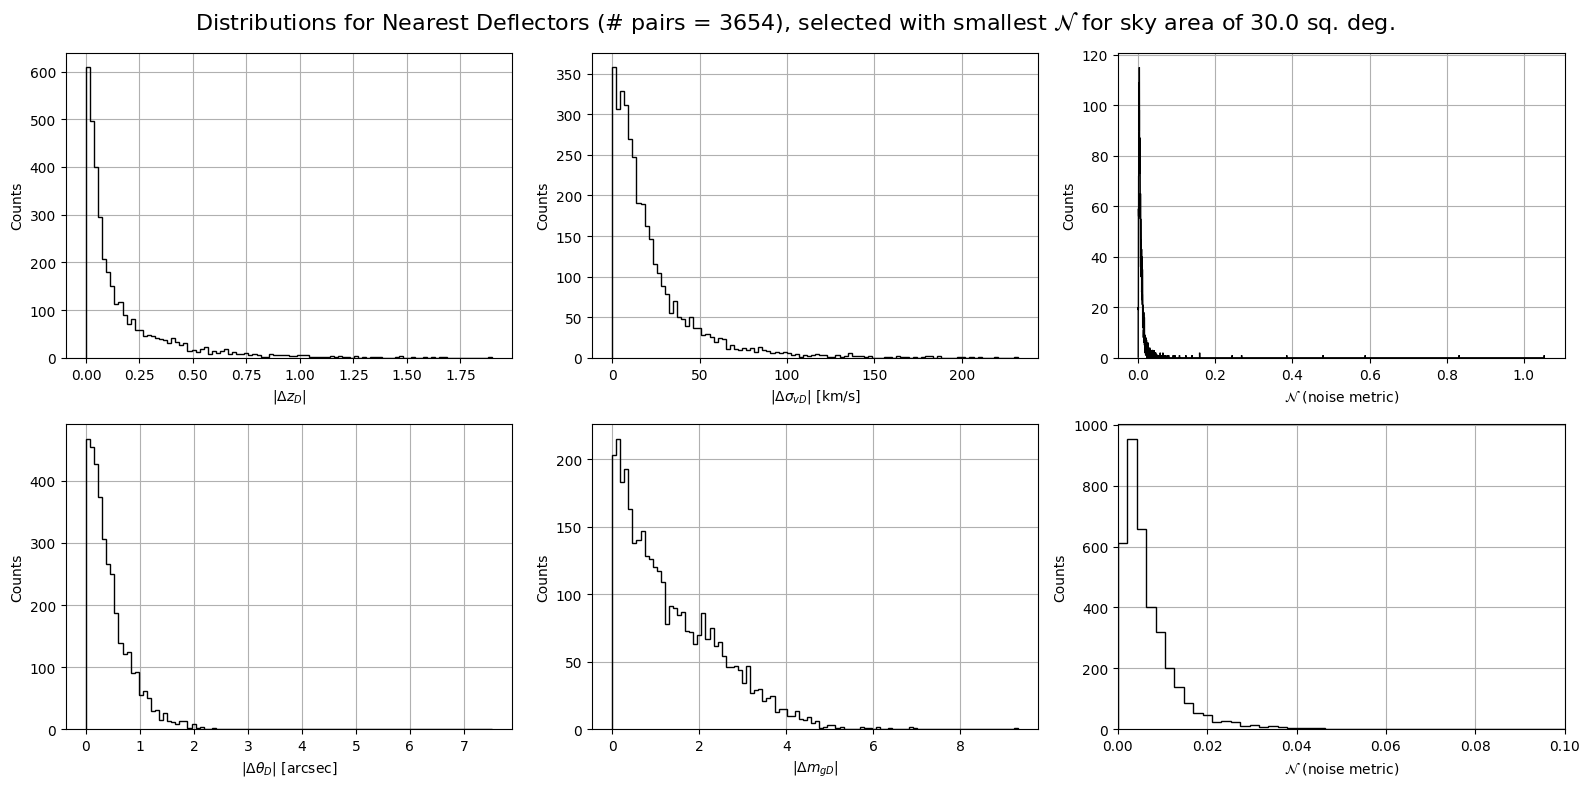

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

# plot the distribution of abs_delta_z_D, abs_delta_sigma_v_D, abs_delta_size_D, abs_delta_mag_i_D
latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$ [km/s]",
    "abs_delta_size_D": r"$|\Delta \theta_D|$ [arcsec]",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
}
for i, param in enumerate(["abs_delta_z_D", "abs_delta_sigma_v_D", "abs_delta_size_D", "abs_delta_mag_g_D"]):
    ax[i//2, i%2].hist(
        nearest_deflector_pairs[param],
        histtype='step',
        color='black',
        bins=100,
    )
    ax[i//2, i%2].set_xlabel(latex_labels[param])
    ax[i//2, i%2].set_ylabel("Counts")
    ax[i//2, i%2].grid(True)

# distribution of N for different ranges
noise_metric = nearest_deflector_pairs['noise_metric']

ax[0, 2].hist(
    noise_metric,
    histtype='step',
    color = 'black',
    bins=5000,
)
# ax[0].set_xlim(0, 20)

ax[1, 2].hist(
    noise_metric[noise_metric < 2],
    histtype='step',
    color = 'black',
    bins=500,
);
ax[1, 2].set_xlim(0, .1)

for a in [ax[0, 2], ax[1, 2]]:
    a.set_xlabel("$\\mathcal{N}$ (noise metric)")
    a.set_ylabel("Counts")
    a.grid(True)

fig.suptitle("Distributions for Nearest Deflectors (# pairs = "+str(len(nearest_deflector_pairs))+"), selected with smallest $\\mathcal{N}$ for sky area of "+str(sky_area_deg2)+" sq. deg.", fontsize=16)
plt.tight_layout()

Scatter of theta_E_ratio vs theta_E1_by_theta_E2_virtual: 0.02058126009030476
Scatter of theta_E_ratio vs theta_E1_virtual_by_theta_E2: 0.02120309857039785


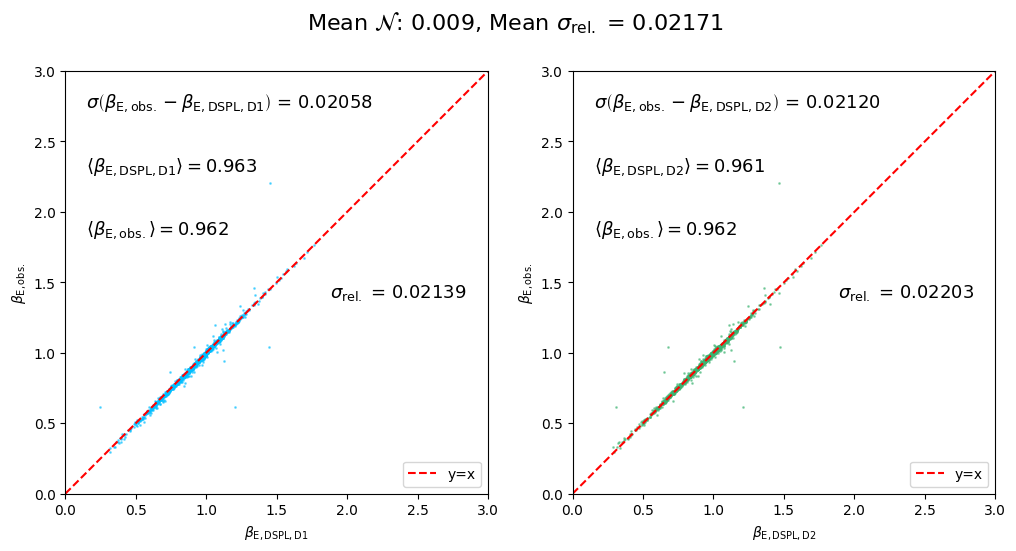

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Plot theta_E_ratio vs theta_E1_by_theta_E2_virtual
ax[0].scatter(
    nearest_deflector_pairs["theta_E1_by_theta_E2_virtual"],
    nearest_deflector_pairs["theta_E_ratio"],
    s=1,
    alpha=0.5,
    color = 'deepskyblue'
)
# ax[0].set_xlabel(r"$\theta_{E1}/\theta_{E2, virtual}$")
# ax[0].set_ylabel(r"$\theta_{E1}/\theta_{E2}$")
ax[0].set_xlabel(r"${\beta}_{\rm E, DSPL,D1}$")
ax[0].set_ylabel(r"${\beta}_{\rm E, obs.}$")

# Plot theta_E_ratio vs theta_E1_virtual_by_theta_E2
ax[1].scatter(
    nearest_deflector_pairs["theta_E1_virtual_by_theta_E2"],
    nearest_deflector_pairs["theta_E_ratio"],
    s=1,
    alpha=0.5,
    color = 'mediumseagreen'
)
# ax[1].set_xlabel(r"$\theta_{E1, virtual}/\theta_{E2}$")
# ax[1].set_ylabel(r"$\theta_{E1}/\theta_{E2}$")
ax[1].set_xlabel(r"${\beta}_{\rm E, DSPL,D2}$")
ax[1].set_ylabel(r"${\beta}_{\rm E, obs.}$")

for a in ax:
    a.set_xlim(0, 3)
    a.set_ylim(0, 3)
    a.plot([0, 10], [0, 10], color='red', linestyle='--', label='y=x')
    a.legend()
    a.set_aspect('equal', adjustable='box')

sigma_1 = np.std(
    nearest_deflector_pairs["theta_E_ratio"] - nearest_deflector_pairs["theta_E1_by_theta_E2_virtual"]
)

sigma_2 = np.std(
    nearest_deflector_pairs["theta_E_ratio"] - nearest_deflector_pairs["theta_E1_virtual_by_theta_E2"]
)

latex_labels = [
    r"$\sigma\left(\beta_{\rm E, obs.} - \beta_{\rm E, DSPL,D1}\right)$",
    r"$\sigma\left(\beta_{\rm E, obs.} - \beta_{\rm E, DSPL,D2}\right)$",
]

# sigma_rel = np.sqrt(sigma_1**2 + sigma_2**2)/ np.mean(nearest_deflector_pairs["theta_E_ratio"])
sigma_rel = (sigma_1 + sigma_2)/ (2*np.mean(nearest_deflector_pairs["theta_E_ratio"]))

# add text for sigmas
ax[0].text(0.05, 0.95, latex_labels[0]+ f" = {sigma_1:.5f}", transform=ax[0].transAxes, fontsize=13, verticalalignment='top')
ax[1].text(0.05, 0.95, latex_labels[1]+ f" = {sigma_2:.5f}", transform=ax[1].transAxes, fontsize=13, verticalalignment='top')

# add text for means
ax[0].text(0.05, 0.80, r"$\langle {\beta}_{\rm E, DSPL,D1} \rangle = $" + f"{np.mean(nearest_deflector_pairs['theta_E1_by_theta_E2_virtual']):.3f}", transform=ax[0].transAxes, fontsize=13, verticalalignment='top')
ax[1].text(0.05, 0.80, r"$\langle {\beta}_{\rm E, DSPL,D2} \rangle = $" + f"{np.mean(nearest_deflector_pairs['theta_E1_virtual_by_theta_E2']):.3f}", transform=ax[1].transAxes, fontsize=13, verticalalignment='top')
ax[0].text(0.05, 0.65, r"$\langle {\beta}_{\rm E, obs.} \rangle = $" + f"{np.mean(nearest_deflector_pairs['theta_E_ratio']):.3f}", transform=ax[0].transAxes, fontsize=13, verticalalignment='top')
ax[1].text(0.05, 0.65, r"$\langle {\beta}_{\rm E, obs.} \rangle = $" + f"{np.mean(nearest_deflector_pairs['theta_E_ratio']):.3f}", transform=ax[1].transAxes, fontsize=13, verticalalignment='top')

# relative sigmas
ax[0].text(0.95, 0.50, r"$\sigma_{\rm rel.}$" + f" = {sigma_1/np.mean(nearest_deflector_pairs['theta_E_ratio']):.5f}", transform=ax[0].transAxes, fontsize=13, verticalalignment='top', horizontalalignment='right')
ax[1].text(0.95, 0.50, r"$\sigma_{\rm rel.}$" + f" = {sigma_2/np.mean(nearest_deflector_pairs['theta_E_ratio']):.5f}", transform=ax[1].transAxes, fontsize=13, verticalalignment='top', horizontalalignment='right')

# save the figure
# fig.savefig("../figures/scatter_deflector_self_similarity.pdf", dpi=300, bbox_inches='tight')

fig.suptitle(
    "Mean $\\mathcal{N}$: "+f"{np.mean(nearest_deflector_pairs['noise_metric']):.3f}, "+
    "Mean $\\sigma_{\\rm rel.}$"+ f" = {sigma_rel:.5f}"
    # "\nMean $|\\Delta \\sigma_v|$ = " + f"{np.mean(nearest_deflector_pairs['abs_delta_sigma_v_D']):.5f} km/s, "+
    # "Mean $|\\Delta z_D|$ = " + f"{np.mean(nearest_deflector_pairs['abs_delta_z_D']):.5f}, "+
    # "Mean $|\\Delta \\theta_D|$ = " + f"{np.mean(nearest_deflector_pairs['abs_delta_size_D']):.5f} arcsec, "
    ,fontsize=16,
    y=0.95,
)

# fraction of the data points left after the mask
# print(f"Number of PDSPLs left after the mask: {np.sum(mask)}")
# print(f"Fraction of data points left after the mask: {round(100*np.sum(mask) / len(mask), 3)} %")



# find the scatter for each plot from the fitted line
print("Scatter of theta_E_ratio vs theta_E1_by_theta_E2_virtual:", np.std(
    nearest_deflector_pairs["theta_E_ratio"] - nearest_deflector_pairs["theta_E1_by_theta_E2_virtual"]
))
print("Scatter of theta_E_ratio vs theta_E1_virtual_by_theta_E2:", np.std(
    nearest_deflector_pairs["theta_E_ratio"] - nearest_deflector_pairs["theta_E1_virtual_by_theta_E2"]
))

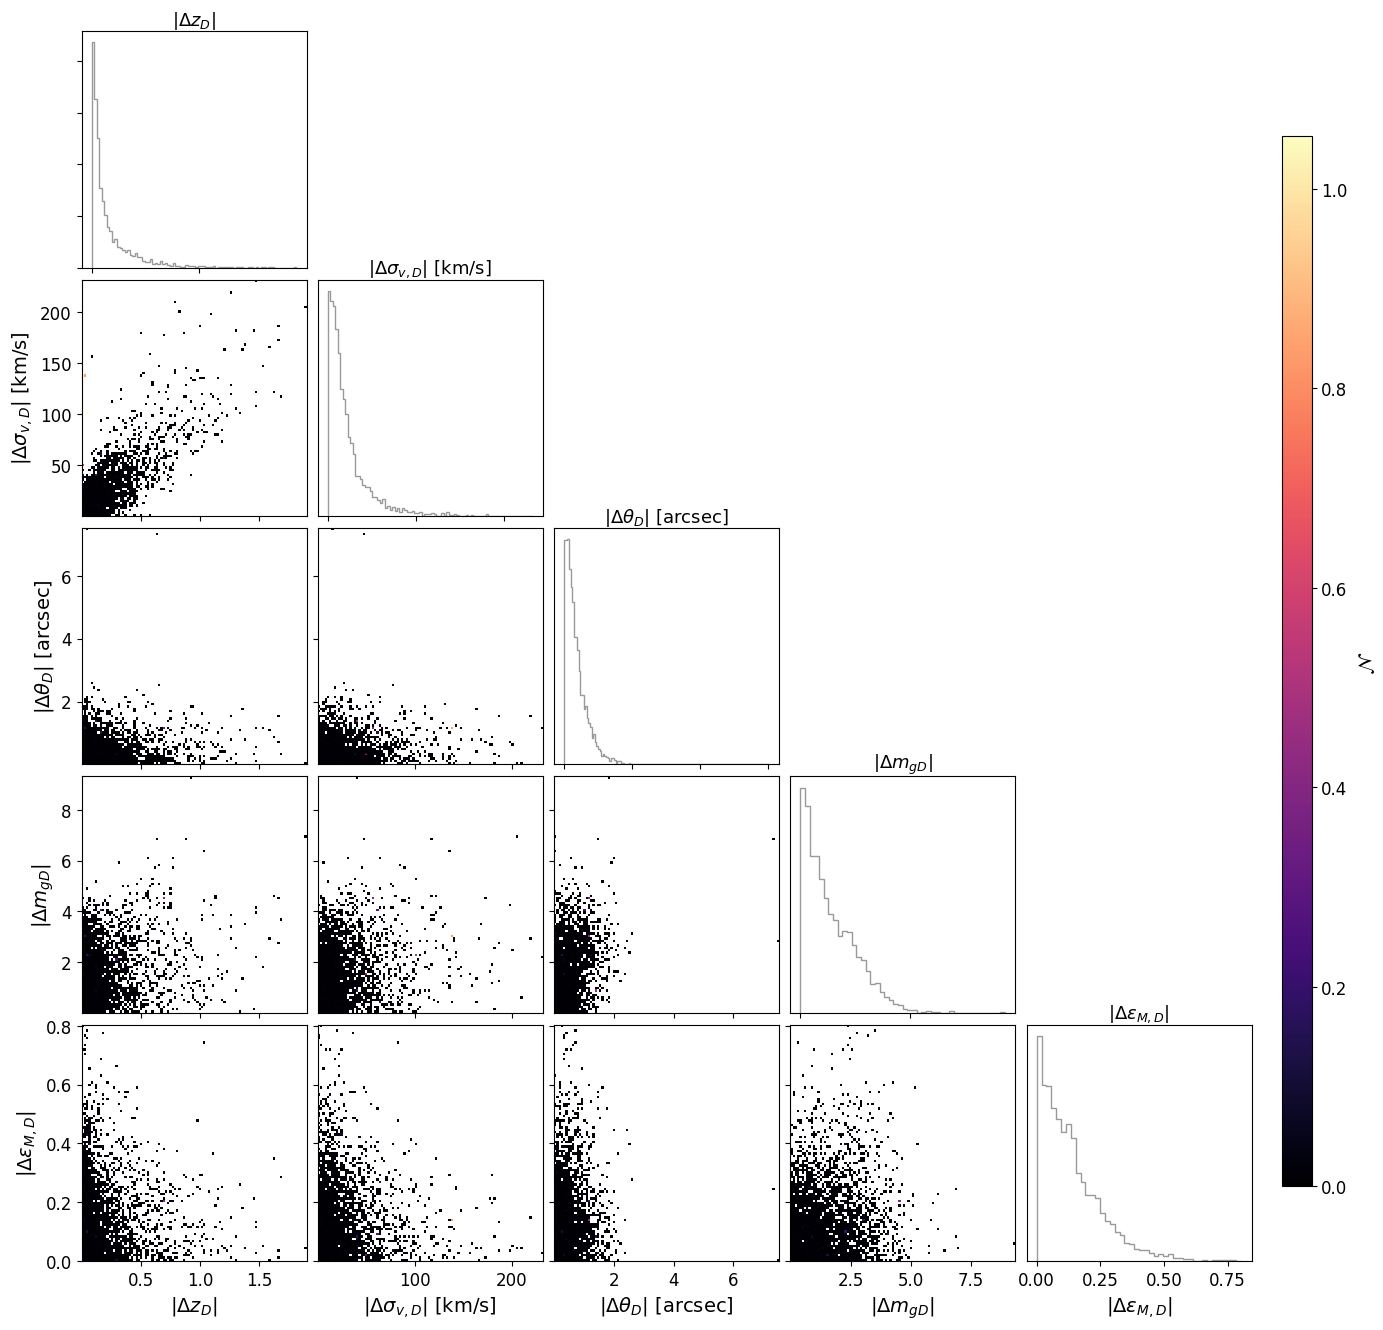

In [54]:
param_keys = [
    "abs_delta_z_D",
    "abs_delta_sigma_v_D",
    "abs_delta_size_D",
    # "abs_delta_mag_i_D",
    # "abs_delta_mag_r_D",
    "abs_delta_mag_g_D",
    # "abs_delta_mag_z_D",
    # "abs_delta_mag_y_D",
    "abs_delta_e_mass_D"
]
latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{v,D}|$ [km/s]",
    "abs_delta_size_D": r"$|\Delta \theta_D|$ [arcsec]",
    # "abs_delta_mag_i_D": r"$|\Delta m_{iD}|$",
    # "abs_delta_mag_r_D": r"$|\Delta m_{rD}|$",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
    # "abs_delta_mag_z_D": r"$|\Delta m_{zD}|$",
    # "abs_delta_mag_y_D": r"$|\Delta m_{yD}|$",
    "abs_delta_e_mass_D": r"$|\Delta \epsilon_{M,D}|$",
}

param_ranges = [
    (0, 0.52),  # abs_delta_z_D
    (0, 39),  # abs_delta_sigma_v_D
    (0, 0.62),  # abs_delta_size_D
    # (0, 2),    # abs_delta_mag_i_D
    # (0, 2),    # abs_delta_mag_r_D
    (0, 2.2),    # abs_delta_mag_g_D
    # (0, 2),    # abs_delta_mag_z_D
    # (0, 2),    # abs_delta_mag_y_D
    (0, 0.7)   # abs_delta_e_mass_D
]

coloring_array = nearest_deflector_pairs["noise_metric"]
# coloring_array = np.exp(-coloring_array**2)

fig = plot_corner_heatmap(nearest_deflector_pairs, param_keys, latex_labels, 
                    coloring_data=coloring_array, 
                    coloring_data_label="$\\mathcal{N}$",
                    # coloring_data_label="$\\exp(-\\mathcal{N}^2)$",
                    cmap='magma', 
                    # param_ranges=param_ranges,
                    heatmap_bins=100,
                    contour_levels=np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975])*np.max(coloring_array),
                    contour_kwargs={'colors': 'k', 'linewidths': 1, 'alpha': 1, 'linestyles': '--'},
                    base_fontsize=14)  # Increased base font size for better visibility

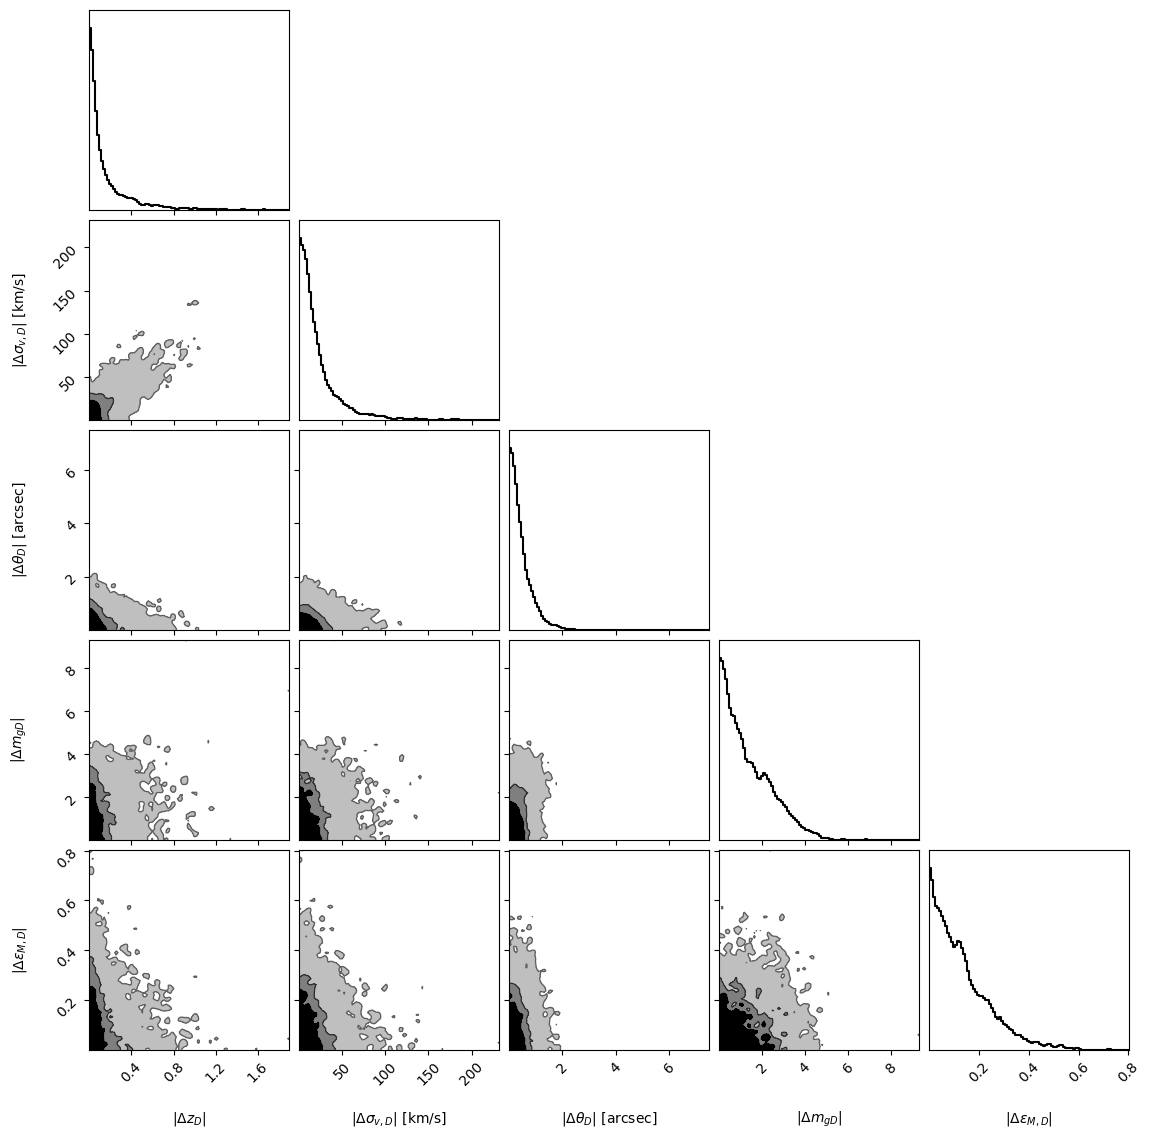

In [55]:
# corner plot 
dict_nearest_deflector_pairs = {
    key: nearest_deflector_pairs[key] for key in param_keys
}


corner.corner(
    dict_nearest_deflector_pairs,
    labels=[latex_labels[key] for key in param_keys],
    color='black',
    bins=100,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    fill_contours=True,
    contour_kwargs={'colors': 'k', 'linewidths': 1, 'alpha': 0.5},
    levels=[0.5, 0.68, 0.95],
);

(0.0, 0.1)

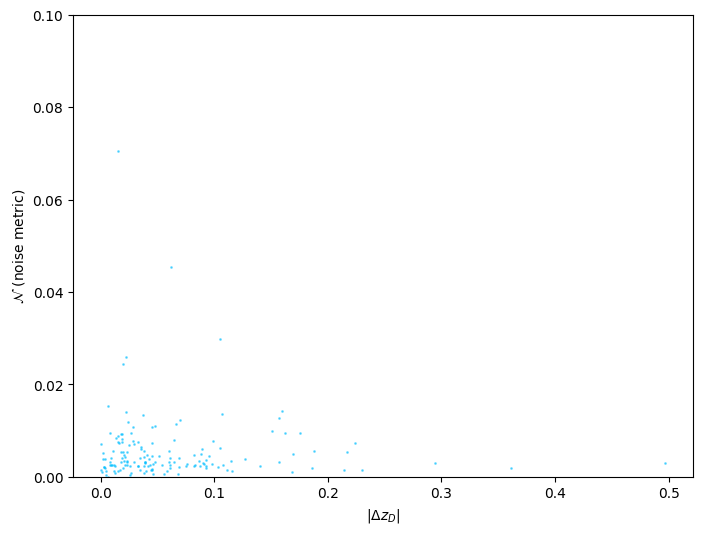

In [56]:
mask = nearest_deflector_pairs["abs_delta_sigma_v_D"] < 1

# plot abs_delta_z_D vs noise_metric
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    nearest_deflector_pairs["abs_delta_z_D"][mask],
    nearest_deflector_pairs["noise_metric"][mask],
    s=1,
    alpha=0.5,
    color='deepskyblue'
)
ax.set_xlabel(r"$|\Delta z_D|$")
ax.set_ylabel(r"$\mathcal{N}$ (noise metric)")
ax.set_ylim(0, 0.1)

(0.0, 0.1)

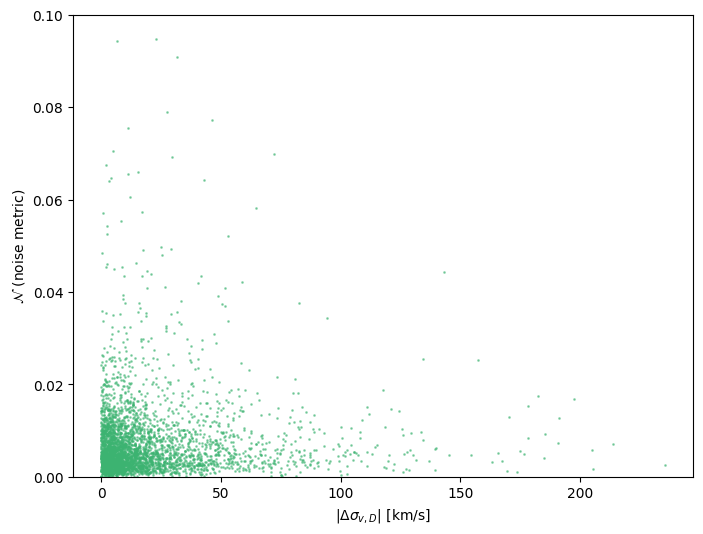

In [83]:
# plot abs_delta_sigma_v_D vs noise_metric
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    nearest_deflector_pairs["abs_delta_sigma_v_D"],
    nearest_deflector_pairs["noise_metric"],
    s=1,
    alpha=0.5,
    color='mediumseagreen'
)
ax.set_xlabel(r"$|\Delta \sigma_{v,D}|$ [km/s]")
ax.set_ylabel(r"$\mathcal{N}$ (noise metric)")
ax.set_ylim(0, 0.1)

### Nearest Deflector Pairs with very high $\Delta z$ and $\Delta \sigma_v$

In [57]:
specific_nearest_deflector_pairs = nearest_deflector_pairs[
    (nearest_deflector_pairs["abs_delta_z_D"] > 0.1) &
    (nearest_deflector_pairs["abs_delta_sigma_v_D"] > 10)
]

# print the number of specific nearest deflector pairs
print("Original number of nearest deflector pairs:", len(nearest_deflector_pairs))
print("Number of specific nearest deflector pairs:", len(specific_nearest_deflector_pairs))
print(f"Fraction of specific nearest deflector pairs: {100 * len(specific_nearest_deflector_pairs) / len(nearest_deflector_pairs):.2f}%")

specific_nearest_deflector_pairs

Original number of nearest deflector pairs: 3654
Number of specific nearest deflector pairs: 1348
Fraction of specific nearest deflector pairs: 36.89%


<Table length=1348>
        z_D1                 z_D2        ...      noise_metric    
                                         ...                      
      float64              float64       ...        float64       
-------------------- ------------------- ... ---------------------
0.036932538736108085  0.6736687044119333 ...  0.007078503167848721
 0.05491269490057095  0.6131823743754108 ... 0.0029435631006876194
0.059844463574798015  0.9674675323013447 ...  0.002738033892951631
 0.07023950722108106 0.21065534341998535 ...  0.005127340087723399
 0.08006182364855438 0.21877458329297378 ...  0.024045618912475406
  0.0831501119835232  0.1859687977675598 ...   0.03652455686099901
 0.09397993241890112 0.46920661603208297 ...  0.009653992183057914
 0.10178323312945348  0.9033095533284324 ...  0.002975754377051141
 0.10372935397443445 0.49112522494261646 ...   0.00543881907889236
                 ...                 ... ...                   ...
  2.2843900904470402  2.4824857950206174 ...  0.031122876286462976
   2.289079966225687  2.4848011494445488 ...  0.025566497607018773
   2.316082997995174   2.452061990532321 ...  0.020829344800113867
   2.324794544660246  2.4300773177656807 ...  0.006637184378089446
  2.3280427324643047   2.397166325072177 ...  0.014348731885104243
   2.328948275937702  2.4789366540534012 ...    0.4793035339426649
  2.3331138933356974   2.452061990532321 ...   0.04793830706681604
  2.3512051875740907  2.4848011494445488 ...    0.2680959847854443
  2.3568614194592588   2.438600611405904 ...  0.007970814619647118

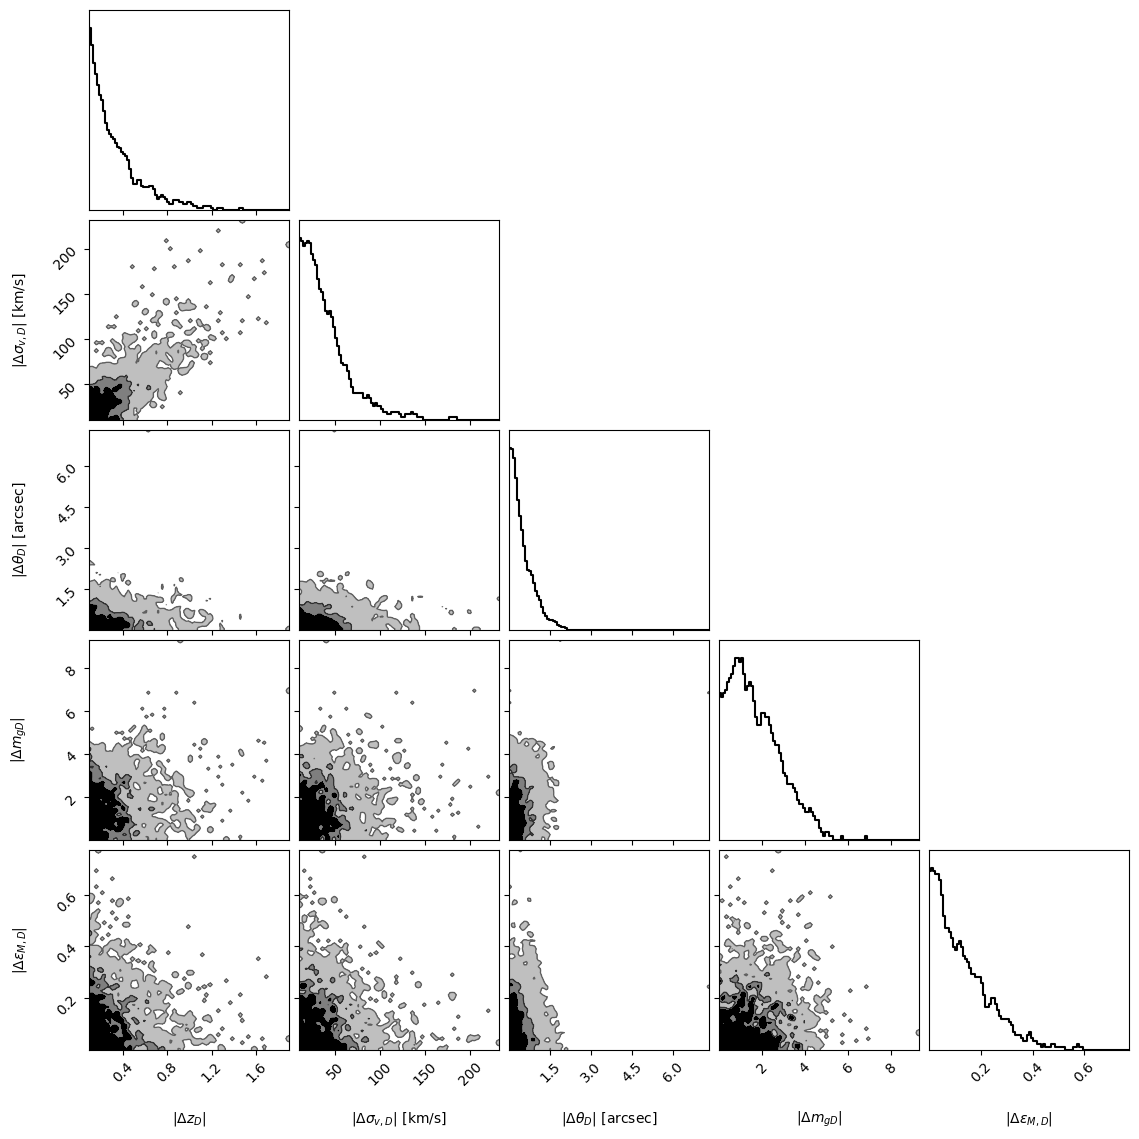

In [58]:
# corner plot 
dict_specific_nearest_deflector_pairs = {
    key: specific_nearest_deflector_pairs[key] for key in param_keys
}


corner.corner(
    dict_specific_nearest_deflector_pairs,
    labels=[latex_labels[key] for key in param_keys],
    color='black',
    bins=100,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    fill_contours=True,
    contour_kwargs={'colors': 'k', 'linewidths': 1, 'alpha': 0.5},
    levels=[0.5, 0.68, 0.95],
);

### Pairs with very small $\mathcal{N}$

In [60]:
small_noise_metric_pairs = loaded_pairing_parameters_table[
    (loaded_pairing_parameters_table["noise_metric"] < 0.001)
]

# print the number of specific nearest deflector pairs
print("Original number of deflector pairs:", len(loaded_pairing_parameters_table))
print("Number of small noise metric deflector pairs:", len(small_noise_metric_pairs))
print(f"Fraction of small noise metric deflector pairs: {100 * len(small_noise_metric_pairs) / len(loaded_pairing_parameters_table):.4f}%")

small_noise_metric_pairs

Original number of deflector pairs: 6594774
Number of small noise metric deflector pairs: 189
Fraction of small noise metric deflector pairs: 0.0029%


<Table length=189>
        z_D1               z_D2        ...      noise_metric     
                                       ...                       
      float64            float64       ...        float64        
------------------- ------------------ ... ----------------------
 0.4135299864120166  0.420584159040367 ... 0.00014096559027279668
 0.9094930427574115  1.291425622878754 ...  0.0008562825716923296
  0.582818733415076 0.8148445939363677 ...  0.0007131769337464756
 0.5841648756560134 0.6049196300151213 ...  0.0002051182439059533
0.45403287705692325 0.8043100208883583 ... 0.00032830309821218107
 0.9672137274009329  1.065340892486099 ...  0.0008361323315172289
 1.1060437087250063 1.5746700638492015 ...  0.0008139759208030861
 0.9876557717215868 1.0456320801020174 ...  0.0008161390069792648
 0.8217761102237048 1.1536743239825582 ...  0.0007247245406786633
                ...                ... ...                    ...
 1.2051603668203263 1.3403825759769747 ...  0.0007766807024256003
 0.9396747493250174 0.9540810255580789 ...  0.0009662122863068158
0.22337015101591026 0.2263137371320055 ... 0.00010569432267561651
 0.5255860868091101 0.5445561127763471 ...  0.0006786121908975491
 1.0850191319119842   1.17198665744405 ...  0.0008143195995003835
 1.2059459519133988 1.2140599228212556 ...  0.0005962680956164125
  0.771730394339454 0.8023234665069829 ...  0.0005827445738762847
 0.7463278910126413  0.755879139455211 ...    0.00086977275474492
 0.7278500728526114  0.959259506378263 ...  0.0005603831143577639

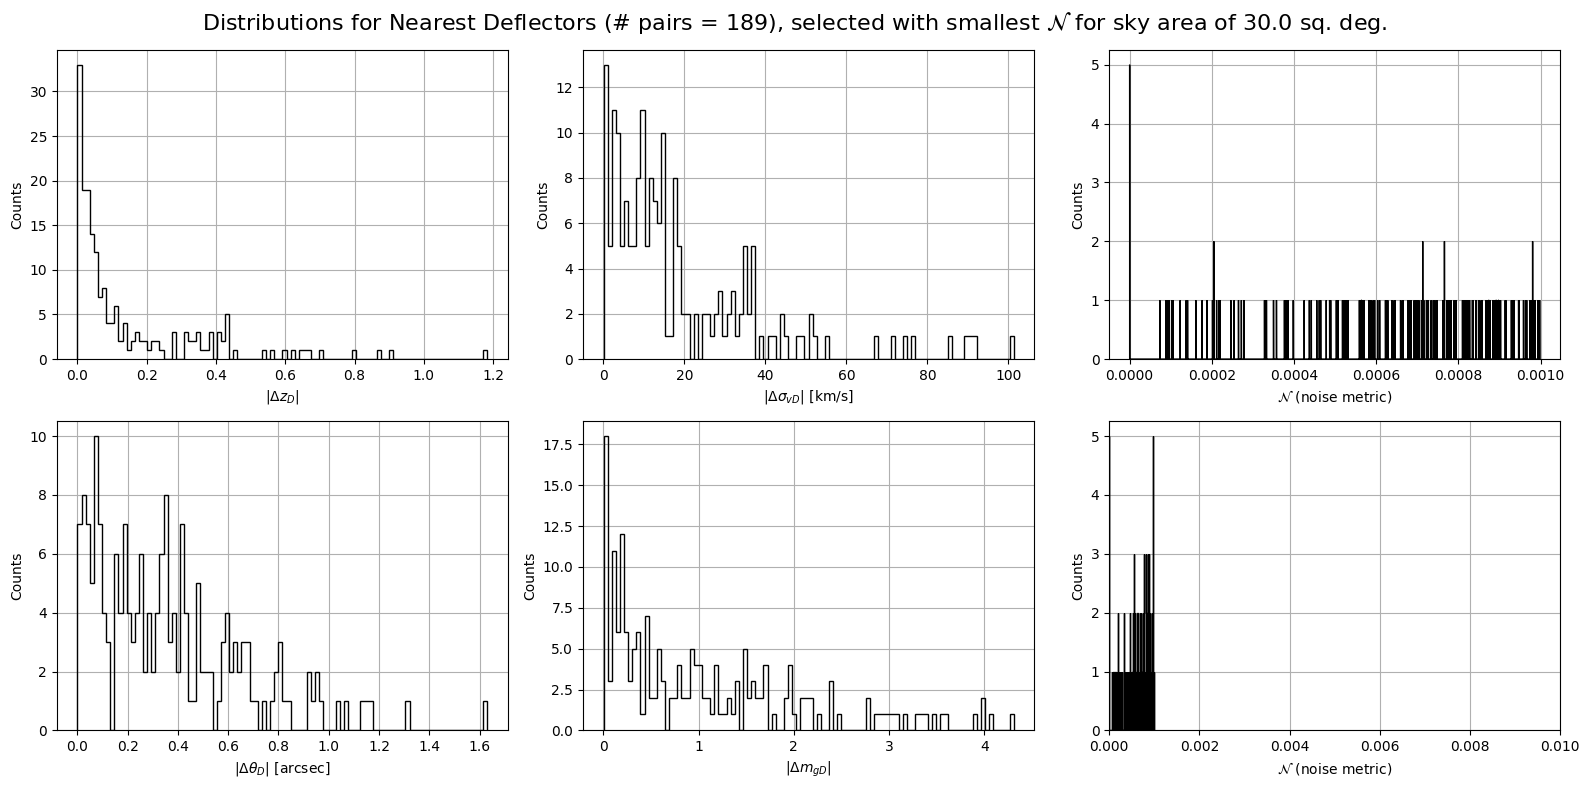

In [61]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

# plot the distribution of abs_delta_z_D, abs_delta_sigma_v_D, abs_delta_size_D, abs_delta_mag_i_D
latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$ [km/s]",
    "abs_delta_size_D": r"$|\Delta \theta_D|$ [arcsec]",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
}
for i, param in enumerate(["abs_delta_z_D", "abs_delta_sigma_v_D", "abs_delta_size_D", "abs_delta_mag_g_D"]):
    ax[i//2, i%2].hist(
        small_noise_metric_pairs[param],
        histtype='step',
        color='black',
        bins=100,
    )
    ax[i//2, i%2].set_xlabel(latex_labels[param])
    ax[i//2, i%2].set_ylabel("Counts")
    ax[i//2, i%2].grid(True)

# distribution of N for different ranges
noise_metric = small_noise_metric_pairs['noise_metric']

ax[0, 2].hist(
    noise_metric,
    histtype='step',
    color = 'black',
    bins=5000,
)
# ax[0].set_xlim(0, 20)

ax[1, 2].hist(
    noise_metric[noise_metric < 2],
    histtype='step',
    color = 'black',
    bins=500,
);
ax[1, 2].set_xlim(0, .01)

for a in [ax[0, 2], ax[1, 2]]:
    a.set_xlabel("$\\mathcal{N}$ (noise metric)")
    a.set_ylabel("Counts")
    a.grid(True)

fig.suptitle("Distributions for Nearest Deflectors (# pairs = "+str(len(small_noise_metric_pairs))+"), selected with smallest $\\mathcal{N}$ for sky area of "+str(sky_area_deg2)+" sq. deg.", fontsize=16)
plt.tight_layout()

In [62]:
# print one such fully identical pairs in a pretty way
# column 1 = deflector 1, column 2 = deflector 2

idx = 10  # index of the pair to print

print("---------- Deflector 1 ---------- | ---------- Deflector 2 ----------")
print(f"           z_D1: {small_noise_metric_pairs['z_D1'][idx]:.3f}            |          z_D2: {small_noise_metric_pairs['z_D2'][idx]:.3f}     ")
print(f"     sigma_v_D1: {small_noise_metric_pairs['sigma_v_D1'][idx]:.3f} [km/s]   |     sigma_v_D2: {small_noise_metric_pairs['sigma_v_D2'][idx]:.3f} [km/s]  ")
print(f"          mag_i: {small_noise_metric_pairs['mag_D1_i'][idx]:.3f}           |         mag_i: {small_noise_metric_pairs['mag_D2_i'][idx]:.3f}     ")
print(f"          mag_r: {small_noise_metric_pairs['mag_D1_r'][idx]:.3f}           |         mag_r: {small_noise_metric_pairs['mag_D2_r'][idx]:.3f}     ")
print(f"          mag_g: {small_noise_metric_pairs['mag_D1_g'][idx]:.3f}           |         mag_g: {small_noise_metric_pairs['mag_D2_g'][idx]:.3f}     ")
print(f"          mag_z: {small_noise_metric_pairs['mag_D1_z'][idx]:.3f}           |         mag_z: {small_noise_metric_pairs['mag_D2_z'][idx]:.3f}     ")
print(f"          mag_y: {small_noise_metric_pairs['mag_D1_y'][idx]:.3f}           |         mag_y: {small_noise_metric_pairs['mag_D2_y'][idx]:.3f}     ")
print(f"         size_D: {small_noise_metric_pairs['size_D1'][idx]:.3f} [arcsec]   |        size_D: {small_noise_metric_pairs['size_D2'][idx]:.3f} [arcsec]  ")
print(f"       e_mass_D: {small_noise_metric_pairs['e_mass_D1'][idx]:.3f} [e_mass]   |    e_mass_D: {small_noise_metric_pairs['e_mass_D2'][idx]:.3f} [e_mass]  ")
print(f"       theta_E1: {small_noise_metric_pairs['theta_E1'][idx]:.3f} [arcsec]   |      theta_E2: {small_noise_metric_pairs['theta_E2'][idx]:.3f} [arcsec]  ")
print(f"  theta_E2_virt: {small_noise_metric_pairs['theta_E2_virtual'][idx]:.3f} [arcsec]   | theta_E1_virt: {small_noise_metric_pairs['theta_E1_virtual'][idx]:.3f} [arcsec]")
print(f"---------------------------------------------------------------------")
print(f"       theta_E1/theta_E2: {small_noise_metric_pairs['theta_E_ratio'][idx]:.3f}")
print(f"  theta_E1/theta_E2_virt: {small_noise_metric_pairs['theta_E1_by_theta_E2_virtual'][idx]:.3f}")
print(f"  theta_E1_virt/theta_E2: {small_noise_metric_pairs['theta_E1_virtual_by_theta_E2'][idx]:.3f}")

---------- Deflector 1 ---------- | ---------- Deflector 2 ----------
           z_D1: 0.642            |          z_D2: 0.680     
     sigma_v_D1: 233.227 [km/s]   |     sigma_v_D2: 236.119 [km/s]  
          mag_i: 20.263           |         mag_i: 20.377     
          mag_r: 21.320           |         mag_r: 21.490     
          mag_g: 22.434           |         mag_g: 22.631     
          mag_z: 19.833           |         mag_z: 19.937     
          mag_y: 19.490           |         mag_y: 19.644     
         size_D: 0.507 [arcsec]   |        size_D: 0.591 [arcsec]  
       e_mass_D: 0.024 [e_mass]   |    e_mass_D: 0.263 [e_mass]  
       theta_E1: 0.968 [arcsec]   |      theta_E2: 0.980 [arcsec]  
  theta_E2_virt: 0.980 [arcsec]   | theta_E1_virt: 0.967 [arcsec]
---------------------------------------------------------------------
       theta_E1/theta_E2: 0.987
  theta_E1/theta_E2_virt: 0.988
  theta_E1_virt/theta_E2: 0.987


## NEAREST DEFLECTOR PAIRS BASED ON THE DEFLECTOR PROPERTIES

Text(0.5, 0.98, 'Corner Plot with Exponential Noise Metric Coloring (# pairs = 6594774)')

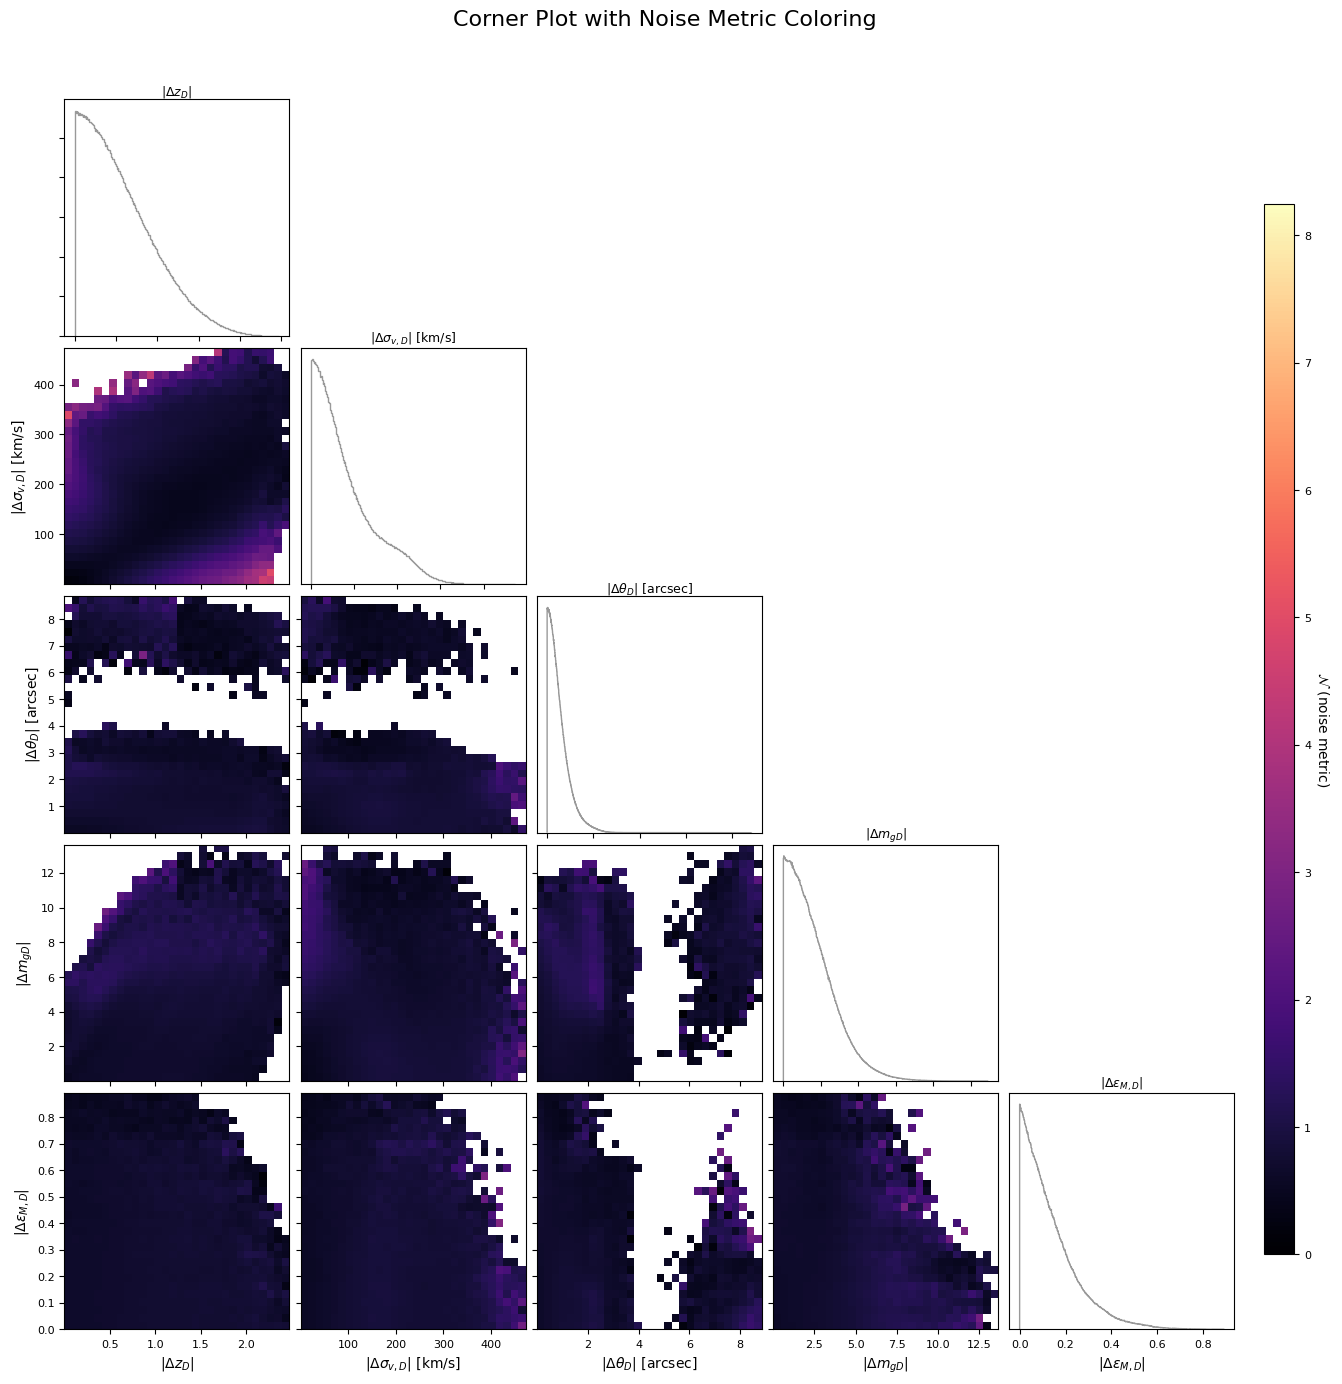

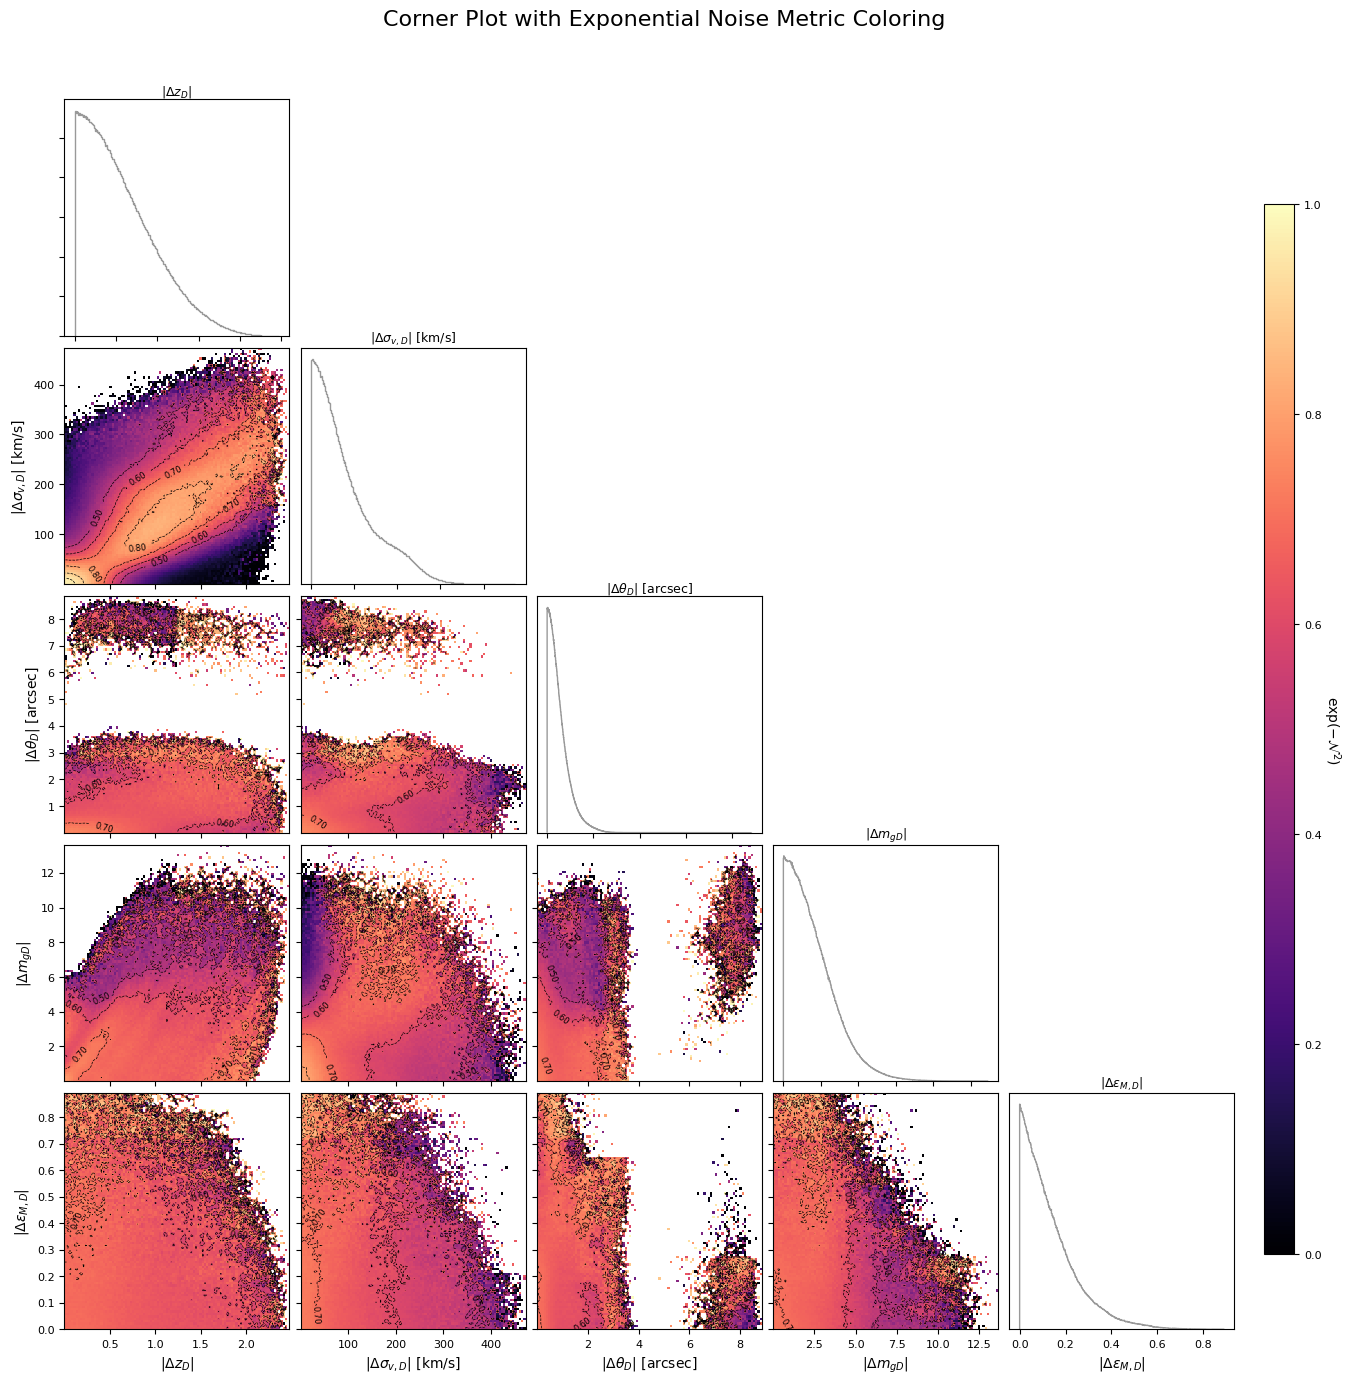

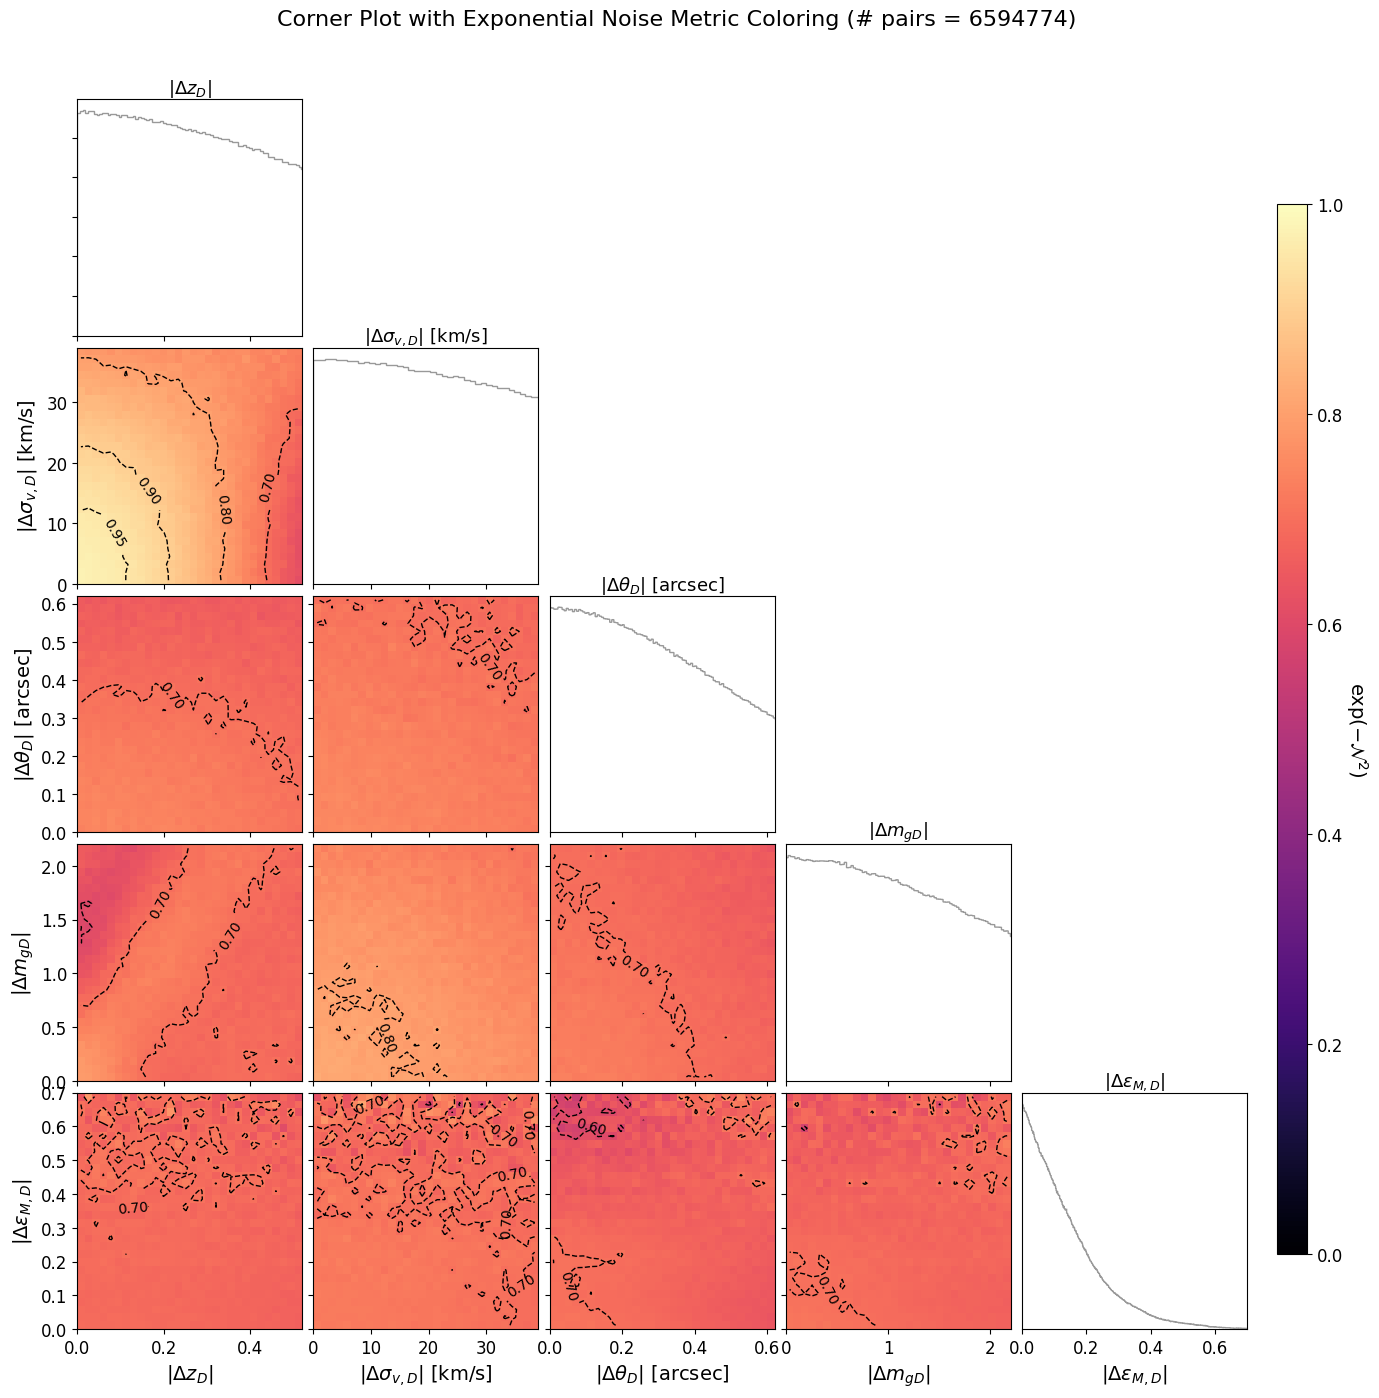

In [63]:
param_keys = [
    "abs_delta_z_D",
    "abs_delta_sigma_v_D",
    "abs_delta_size_D",
    # "abs_delta_mag_i_D",
    # "abs_delta_mag_r_D",
    "abs_delta_mag_g_D",
    # "abs_delta_mag_z_D",
    # "abs_delta_mag_y_D",
    "abs_delta_e_mass_D"
]
latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{v,D}|$ [km/s]",
    "abs_delta_size_D": r"$|\Delta \theta_D|$ [arcsec]",
    # "abs_delta_mag_i_D": r"$|\Delta m_{iD}|$",
    # "abs_delta_mag_r_D": r"$|\Delta m_{rD}|$",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
    # "abs_delta_mag_z_D": r"$|\Delta m_{zD}|$",
    # "abs_delta_mag_y_D": r"$|\Delta m_{yD}|$",
    "abs_delta_e_mass_D": r"$|\Delta \epsilon_{M,D}|$",
}

param_ranges = [
    (0, 0.52),  # abs_delta_z_D
    (0, 39),  # abs_delta_sigma_v_D
    (0, 0.62),  # abs_delta_size_D
    # (0, 2),    # abs_delta_mag_i_D
    # (0, 2),    # abs_delta_mag_r_D
    (0, 2.2),    # abs_delta_mag_g_D
    # (0, 2),    # abs_delta_mag_z_D
    # (0, 2),    # abs_delta_mag_y_D
    (0, 0.7)   # abs_delta_e_mass_D
]

## 1. Generate a corner plot with coloring based on noise metric
coloring_array = loaded_pairing_parameters_table["noise_metric"]
# coloring_array = -coloring_array
fig = plot_corner_heatmap(loaded_pairing_parameters_table, param_keys, latex_labels, 
                    coloring_data=coloring_array, coloring_data_label="$\\mathcal{N}$ (noise metric)",
                    cmap='magma',)
fig.suptitle("Corner Plot with Noise Metric Coloring", fontsize=16, y=0.98)



## 2. Generate a corner plot with coloring based on e^(-noise metric)

coloring_array = loaded_pairing_parameters_table["noise_metric"]
coloring_array = np.exp(-coloring_array**2)

fig = plot_corner_heatmap(loaded_pairing_parameters_table, param_keys, latex_labels, 
                    coloring_data=coloring_array, coloring_data_label="$\\exp(-\\mathcal{N}^2)$",
                    cmap='magma', 
                    # param_ranges=param_ranges,
                    heatmap_bins=100,
                    contour_levels=np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95])*np.max(coloring_array),
                    contour_kwargs={'colors': 'k', 'linewidths': 0.5, 'alpha': 1, 'linestyles': '--'})

fig.suptitle("Corner Plot with Exponential Noise Metric Coloring", fontsize=16, y=0.98)

# 3. Zoom into parameter ranges

coloring_array = loaded_pairing_parameters_table["noise_metric"]
coloring_array = np.exp(-coloring_array**2)

fig = plot_corner_heatmap(loaded_pairing_parameters_table, param_keys, latex_labels, 
                    coloring_data=coloring_array, coloring_data_label="$\\exp(-\\mathcal{N}^2)$",
                    cmap='magma', 
                    param_ranges=param_ranges,
                    heatmap_bins=30,
                    contour_levels=np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975])*np.max(coloring_array),
                    contour_kwargs={'colors': 'k', 'linewidths': 1, 'alpha': 1, 'linestyles': '--'},
                    base_fontsize=14)  # Increased base font size for better visibility
# fig.savefig("../figures/heatmap_deflector_self_similarity.pdf", dpi=300, bbox_inches='tight')

fig.suptitle(f"Corner Plot with Exponential Noise Metric Coloring (# pairs = {len(loaded_pairing_parameters_table)})", fontsize=16, y=0.98)

Text(0.5, 0.98, 'Corner Plot with Exponential Noise Metric Coloring (# pairs = 6594774)')

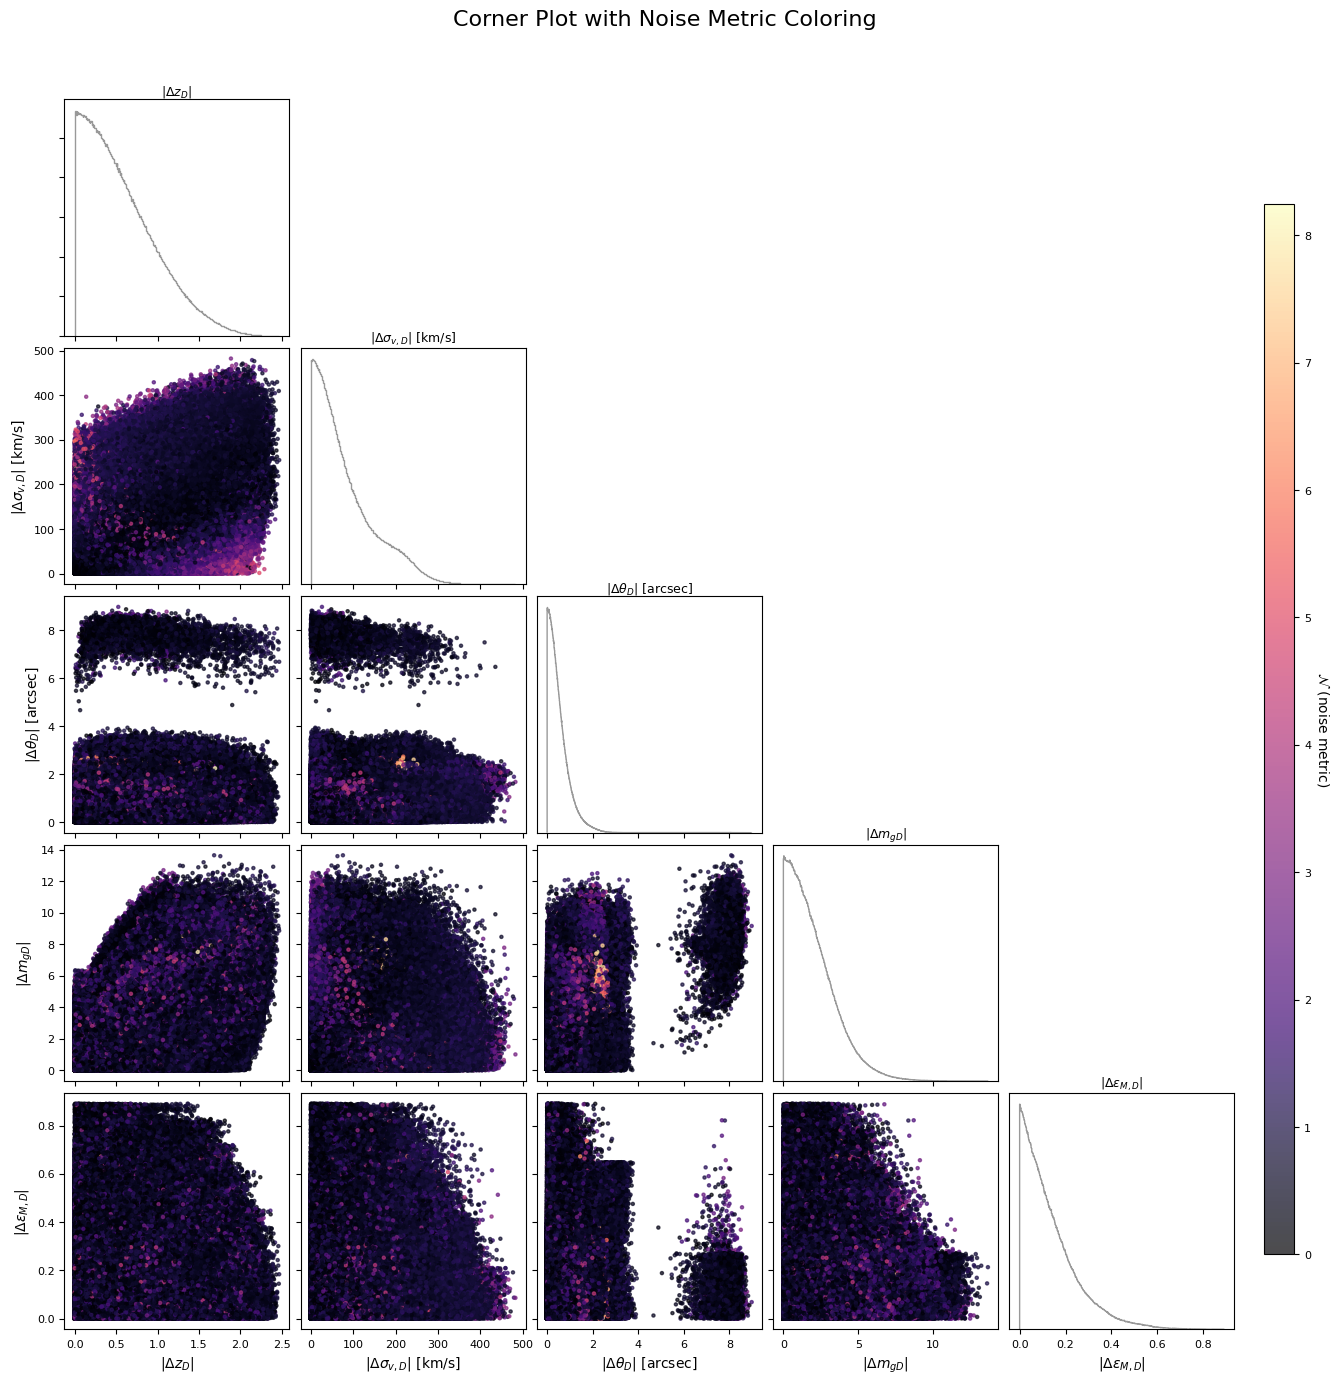

Error in callback <function flush_figures at 0x3205032e0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [9]:
## 1. Generate a corner plot with coloring based on noise metric
coloring_array = loaded_pairing_parameters_table["noise_metric"]
# coloring_array = -coloring_array
fig = plot_corner_scatter(loaded_pairing_parameters_table, param_keys, latex_labels, 
                    coloring_data=coloring_array, coloring_data_label="$\\mathcal{N}$ (noise metric)",
                    cmap='magma',)
fig.suptitle("Corner Plot with Noise Metric Coloring", fontsize=16, y=0.98)



## 2. Generate a corner plot with coloring based on e^(-noise metric)

coloring_array = loaded_pairing_parameters_table["noise_metric"]
coloring_array = np.exp(-coloring_array**2)

fig = plot_corner_scatter(loaded_pairing_parameters_table, param_keys, latex_labels, 
                    coloring_data=coloring_array, coloring_data_label="$\\exp(-\\mathcal{N}^2)$",
                    cmap='magma', 
                    # param_ranges=param_ranges,
                    # contour_levels=np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95])*np.max(coloring_array),
                    # contour_kwargs={'colors': 'k', 'linewidths': 0.5, 'alpha': 1, 'linestyles': '--'}
                    )

fig.suptitle("Corner Plot with Exponential Noise Metric Coloring", fontsize=16, y=0.98)

# 3. Zoom into parameter ranges

coloring_array = loaded_pairing_parameters_table["noise_metric"]
coloring_array = np.exp(-coloring_array**2)

fig = plot_corner_scatter(loaded_pairing_parameters_table, param_keys, latex_labels, 
                    coloring_data=coloring_array, coloring_data_label="$\\exp(-\\mathcal{N}^2)$",
                    cmap='magma', 
                    param_ranges=param_ranges,
                    # contour_levels=np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975])*np.max(coloring_array),
                    # contour_kwargs={'colors': 'k', 'linewidths': 1, 'alpha': 1, 'linestyles': '--'},
                    base_fontsize=14)  # Increased base font size for better visibility
# fig.savefig("../figures/heatmap_deflector_self_similarity.pdf", dpi=300, bbox_inches='tight')

fig.suptitle(f"Corner Plot with Exponential Noise Metric Coloring (# pairs = {len(loaded_pairing_parameters_table)})", fontsize=16, y=0.98)

Text(0.5, 0.98, 'Corner Plot with Noise Metric [RED] (# pairs = 6594774)')

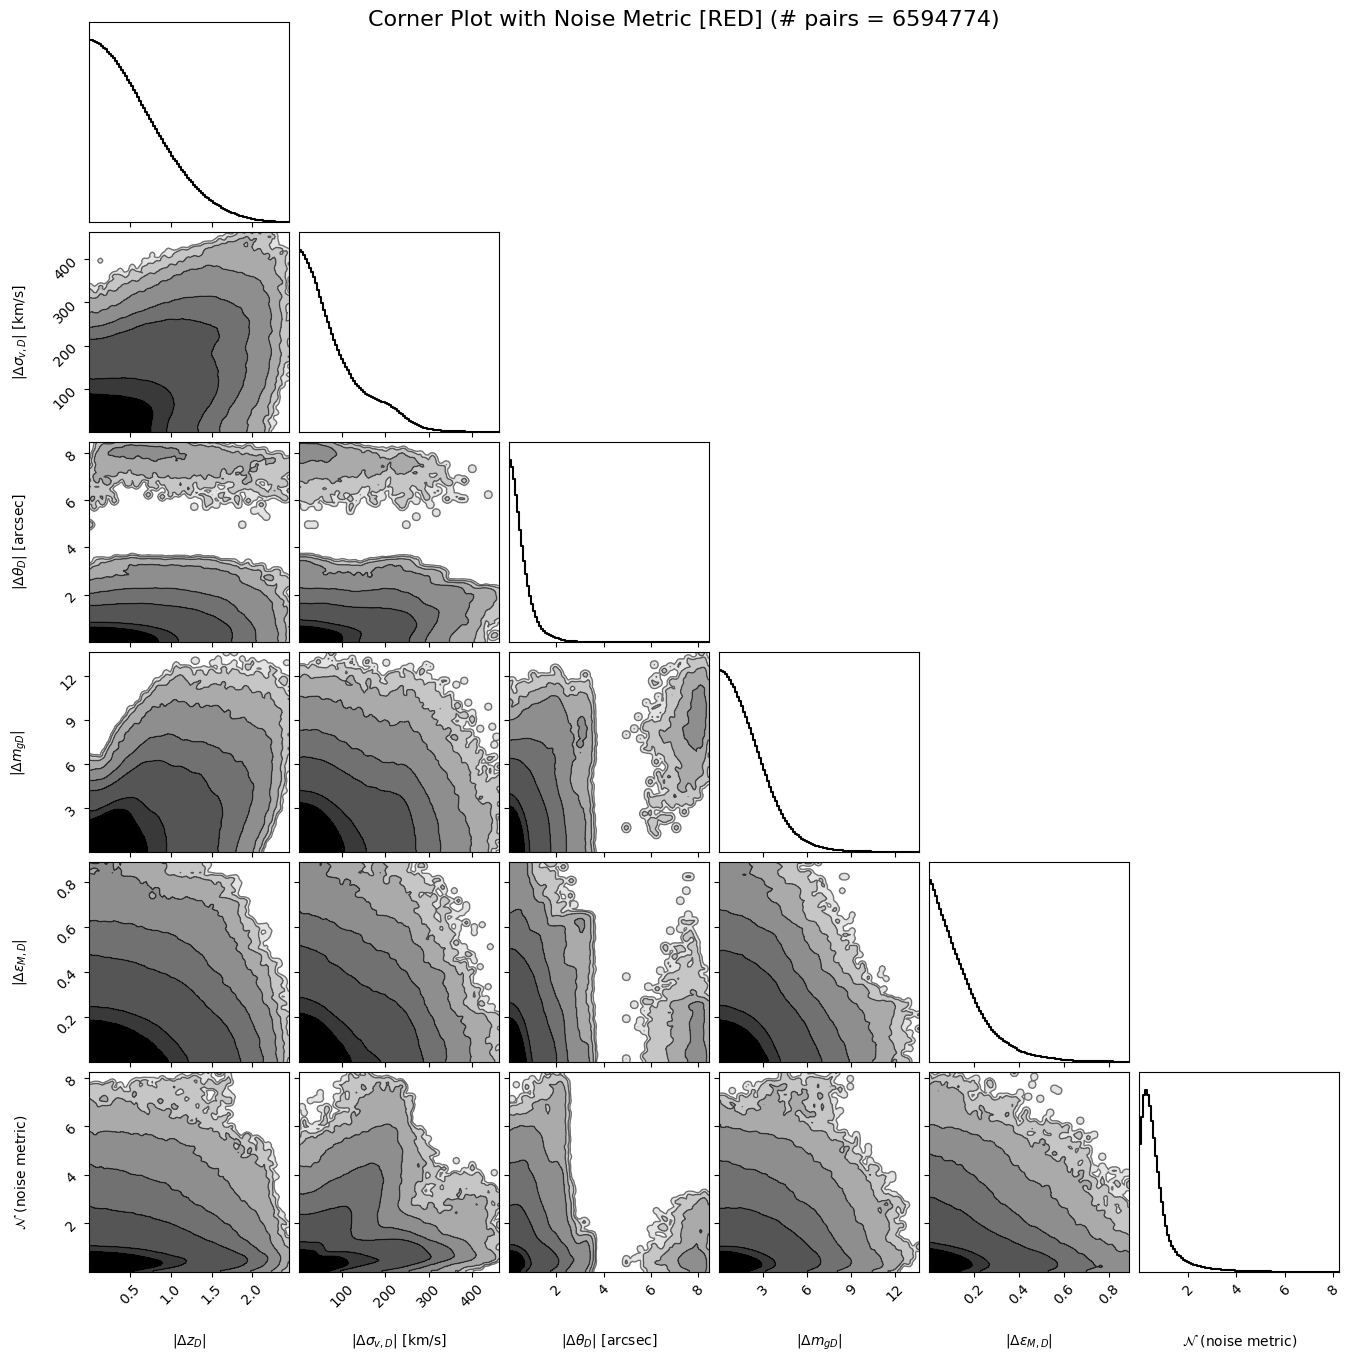

In [53]:
param_keys = [
    "abs_delta_z_D",
    "abs_delta_sigma_v_D",
    "abs_delta_size_D",
    # "abs_delta_mag_i_D",
    # "abs_delta_mag_r_D",
    "abs_delta_mag_g_D",
    # "abs_delta_mag_z_D",
    # "abs_delta_mag_y_D",
    "abs_delta_e_mass_D",
    "noise_metric"
]
latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{v,D}|$ [km/s]",
    "abs_delta_size_D": r"$|\Delta \theta_D|$ [arcsec]",
    # "abs_delta_mag_i_D": r"$|\Delta m_{iD}|$",
    # "abs_delta_mag_r_D": r"$|\Delta m_{rD}|$",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
    # "abs_delta_mag_z_D": r"$|\Delta m_{zD}|$",
    # "abs_delta_mag_y_D": r"$|\Delta m_{yD}|$",
    "abs_delta_e_mass_D": r"$|\Delta \epsilon_{M,D}|$",
    "noise_metric": r"$\mathcal{N}$ (noise metric)"
}
# corner plot 
dict_deflector_pairs = {
    key: loaded_pairing_parameters_table[key] for key in param_keys
}


fig = corner.corner(
    dict_deflector_pairs,
    labels=[latex_labels[key] for key in param_keys],
    color='black',
    bins=100,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    fill_contours=True,
    contour_kwargs={'colors': 'k', 'linewidths': 1, 'alpha': 0.5},
    levels=[0.5, 0.68, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999],
);
fig.suptitle(
    "Corner Plot with Noise Metric [RED] (# pairs = "+str(len(loaded_pairing_parameters_table))+")",
    fontsize=16,
    y=0.98,
)

In [54]:
# put a mask on the pairing parameters to select the nearest deflector pairs

# threshold_abs_delta_z_D = 0.01
# threshold_abs_delta_sigma_v_D = 10 # km/s
# threshold_abs_delta_size_D = 0.7 # arcsec
# threshold_abs_delta_mag_X_D = 0.01 # mag

threshold_abs_delta_z_D = 0.15
threshold_abs_delta_sigma_v_D = 40 # km/s
threshold_abs_delta_size_D = 1 # arcsec
threshold_abs_delta_mag_X_D = 1 # mag

mask = (
    (loaded_pairing_parameters_table["abs_delta_z_D"] < threshold_abs_delta_z_D)
    & (loaded_pairing_parameters_table["abs_delta_sigma_v_D"] < threshold_abs_delta_sigma_v_D)
    & (loaded_pairing_parameters_table["abs_delta_size_D"] < threshold_abs_delta_size_D)
    # & (loaded_pairing_parameters_table["abs_delta_mag_i_D"] < threshold_abs_delta_mag_X_D)
    # & (loaded_pairing_parameters_table["abs_delta_mag_r_D"] < threshold_abs_delta_mag_X_D)
    & (loaded_pairing_parameters_table["abs_delta_mag_g_D"] < threshold_abs_delta_mag_X_D)
    # & (loaded_pairing_parameters_table["abs_delta_mag_z_D"] < threshold_abs_delta_mag_X_D)
    # & (loaded_pairing_parameters_table["abs_delta_mag_y_D"] < threshold_abs_delta_mag_X_D)
    & (loaded_pairing_parameters_table["theta_E1"] < 2)
    & (loaded_pairing_parameters_table["theta_E1"] > 0.1)
    & (loaded_pairing_parameters_table["theta_E2"] < 2)
    & (loaded_pairing_parameters_table["theta_E2"] > 0.1)
    # & (loaded_pairing_parameters_table["theta_E1_by_theta_E2_virtual"] < 2)
    # & (loaded_pairing_parameters_table["theta_E1_virtual_by_theta_E2"] < 2)
    # & (loaded_pairing_parameters_table["theta_E_ratio"] < 2)
    # & (loaded_pairing_parameters_table["theta_E_ratio"] > 0.1)
)

# no identical deflectors
# mask &= (loaded_pairing_parameters_table["abs_delta_z_D"] == 0)

nearest_deflector_pairs_properties = loaded_pairing_parameters_table[mask].copy()


# print number of unique z_D1, z_D2 and combined z_D1, z_D2
print("Number of unique z_D1:", np.unique(nearest_deflector_pairs_properties["z_D1"]).size)
print("Number of unique z_D2:", np.unique(nearest_deflector_pairs_properties["z_D2"]).size)
print("Number of unique combined z_D1, z_D2:", np.unique(np.concatenate([nearest_deflector_pairs_properties["z_D1"], nearest_deflector_pairs_properties["z_D2"]])).size)

Number of unique z_D1: 3544
Number of unique z_D2: 3544
Number of unique combined z_D1, z_D2: 3557


In [55]:
# save the nearest deflector pairs properties table
# nearest_deflector_pairs_properties.write(
#     f"nearest_deflector_pairs_properties_{sky_area_deg2}_sq_deg.fits",
#     format="fits",
#     overwrite=True,
# )
# nearest_deflector_pairs_properties.write(
#     f"fully_identical_deflector_pairs_{sky_area_deg2}_sq_deg.fits",
#     format="fits",
#     overwrite=True,
# )
# print the nearest deflector pairs properties table
nearest_deflector_pairs_properties

<Table length=282607>
       z_D1               z_D2        ...     noise_metric    
                                      ...                     
     float64            float64       ...       float64       
------------------ ------------------ ... --------------------
0.8768567153814093 0.9289855652258872 ...  0.21327860087371633
0.9272705643150501 0.9289855652258872 ...  0.37500451646030775
0.9289855652258872 0.9824463903589125 ... 0.004042342490620017
0.9094930427574115 0.9289855652258872 ...  0.09351591917286135
0.8451069397043176 0.9289855652258872 ... 0.028445018849819276
0.9289855652258872  1.065340892486099 ...  0.21549005773005542
0.9289855652258872 0.9523900899345714 ...  0.27097546756129415
0.9289855652258872   1.06176850863145 ...  0.24404915517968712
0.8217761102237048 0.9289855652258872 ... 0.014512601547374061
               ...                ... ...                  ...
0.3414366983659226 0.3437727577824593 ...  0.21494692996557743
1.0857630626677632 1.0858882442908568 ...  0.19302214259971498
1.0857630626677632   1.10619839885602 ...  0.22503761863389934
1.0857630626677632  1.175232128638186 ...  0.35365813462351275
0.3845880912611209 0.4608898861023956 ... 0.054691911423183456
1.0858882442908568   1.10619839885602 ... 0.047991019041655085
1.0858882442908568  1.175232128638186 ...   0.5761090843960311
1.5535166440094093 1.5901295268334803 ... 0.013616863866179657
0.6492468364489411 0.7480196963080241 ...    0.074684103196102

In [56]:
print(f"Number of fully identical deflector pairs: {len(nearest_deflector_pairs_properties[nearest_deflector_pairs_properties['abs_delta_z_D'] == 0])}")

Number of fully identical deflector pairs: 74


Text(0.5, 0.98, 'Corner Plot with Noise Metric [RED+BLUE] (# pairs = 282607)\nMasked with: $|\\Delta z_D| < 0.15, $ $|\\Delta \\sigma_{v,D}| < 40 \\, \\rm{km/s}, $ \n$|\\Delta \\theta_D| < 1 \\, \\rm{arcsec}, $ $|\\Delta m_{gD}| < 1 \\, \\rm{mag}, $ ')

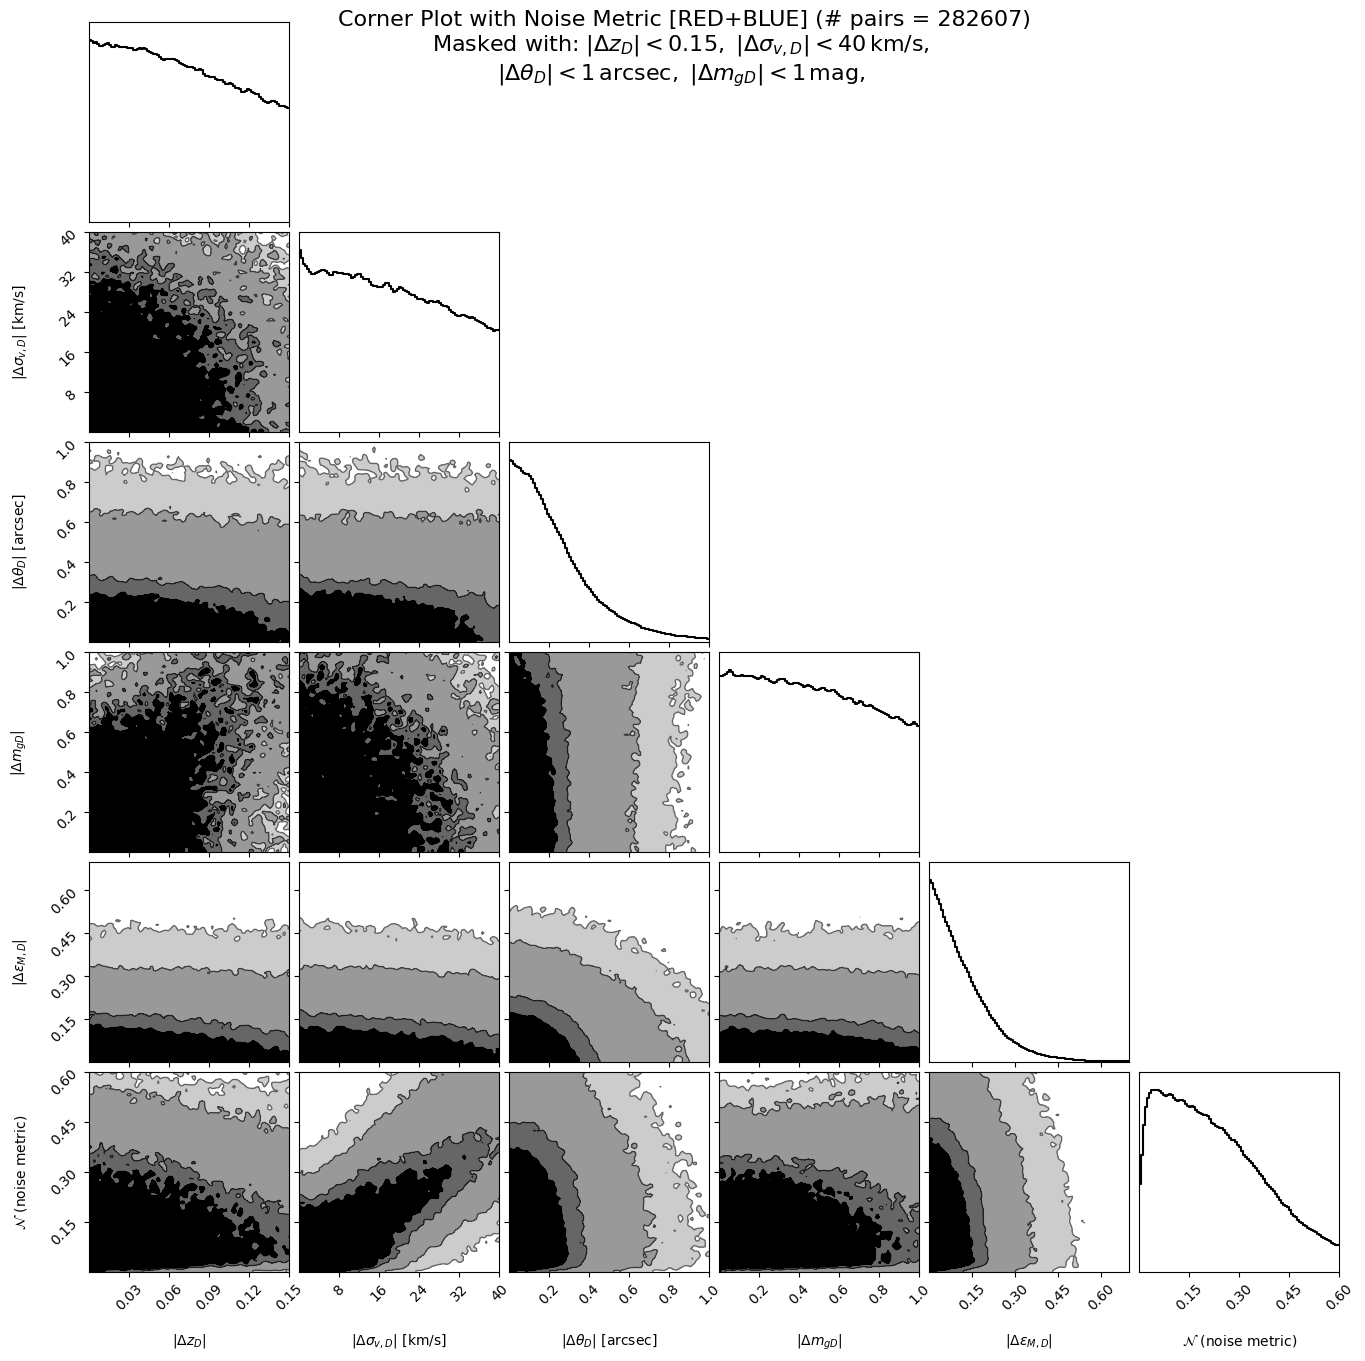

In [58]:
param_keys = [
    "abs_delta_z_D",
    "abs_delta_sigma_v_D",
    "abs_delta_size_D",
    # "abs_delta_mag_i_D",
    # "abs_delta_mag_r_D",
    "abs_delta_mag_g_D",
    # "abs_delta_mag_z_D",
    # "abs_delta_mag_y_D",
    "abs_delta_e_mass_D",
    "noise_metric"
]
latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{v,D}|$ [km/s]",
    "abs_delta_size_D": r"$|\Delta \theta_D|$ [arcsec]",
    # "abs_delta_mag_i_D": r"$|\Delta m_{iD}|$",
    # "abs_delta_mag_r_D": r"$|\Delta m_{rD}|$",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
    # "abs_delta_mag_z_D": r"$|\Delta m_{zD}|$",
    # "abs_delta_mag_y_D": r"$|\Delta m_{yD}|$",
    "abs_delta_e_mass_D": r"$|\Delta \epsilon_{M,D}|$",
    "noise_metric": r"$\mathcal{N}$ (noise metric)"
}

param_ranges = [
    (0, 0.15),  # abs_delta_z_D
    (0, 40),  # abs_delta_sigma_v_D
    (0, 1),  # abs_delta_size_D
    # (0, 2),    # abs_delta_mag_i_D
    # (0, 2),    # abs_delta_mag_r_D
    (0, 1),    # abs_delta_mag_g_D
    # (0, 2),    # abs_delta_mag_z_D
    # (0, 2),    # abs_delta_mag_y_D
    (0, 0.7),   # abs_delta_e_mass_D
    (0, .6)    # noise_metric  
]

# corner plot 
dict_deflector_pairs = {
    key: nearest_deflector_pairs_properties[key] for key in param_keys
}


fig = corner.corner(
    dict_deflector_pairs,
    labels=[latex_labels[key] for key in param_keys],
    color='black',
    bins=100,
    range=param_ranges,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    fill_contours=True,
    contour_kwargs={'colors': 'k', 'linewidths': 1, 'alpha': 0.5},
    levels=[0.5, 0.68, 0.95, 0.99],
);
fig.suptitle(
    "Corner Plot with Noise Metric [RED+BLUE] (# pairs = "+str(len(nearest_deflector_pairs_properties))+")"
    "\nMasked with: "
    f"$|\\Delta z_D| < {threshold_abs_delta_z_D}, $ "
    "$|\\Delta \\sigma_{v,D}| < "+f"{threshold_abs_delta_sigma_v_D} \\, \\rm{{km/s}}, $ "
    f"\n$|\\Delta \\theta_D| < {threshold_abs_delta_size_D} \\, \\rm{{arcsec}}, $ "
    # f"$|\\Delta m_{iD}| < {threshold_abs_delta_mag_X_D}, $ "
    # f"$|\\Delta m_{rD}| < {threshold_abs_delta_mag_X_D}, $ "
    "$|\\Delta m_{gD}| < "+f"{threshold_abs_delta_mag_X_D} \\, \\rm{{mag}}, $ "
    # f"$|\\Delta m_{zD}| < {threshold_abs_delta_mag_X_D}, $ "
    # f"$|\\Delta m_{yD}| < {threshold_abs_delta_mag_X_D}, $ "
    ,
    fontsize=16,
    y=0.98,
)

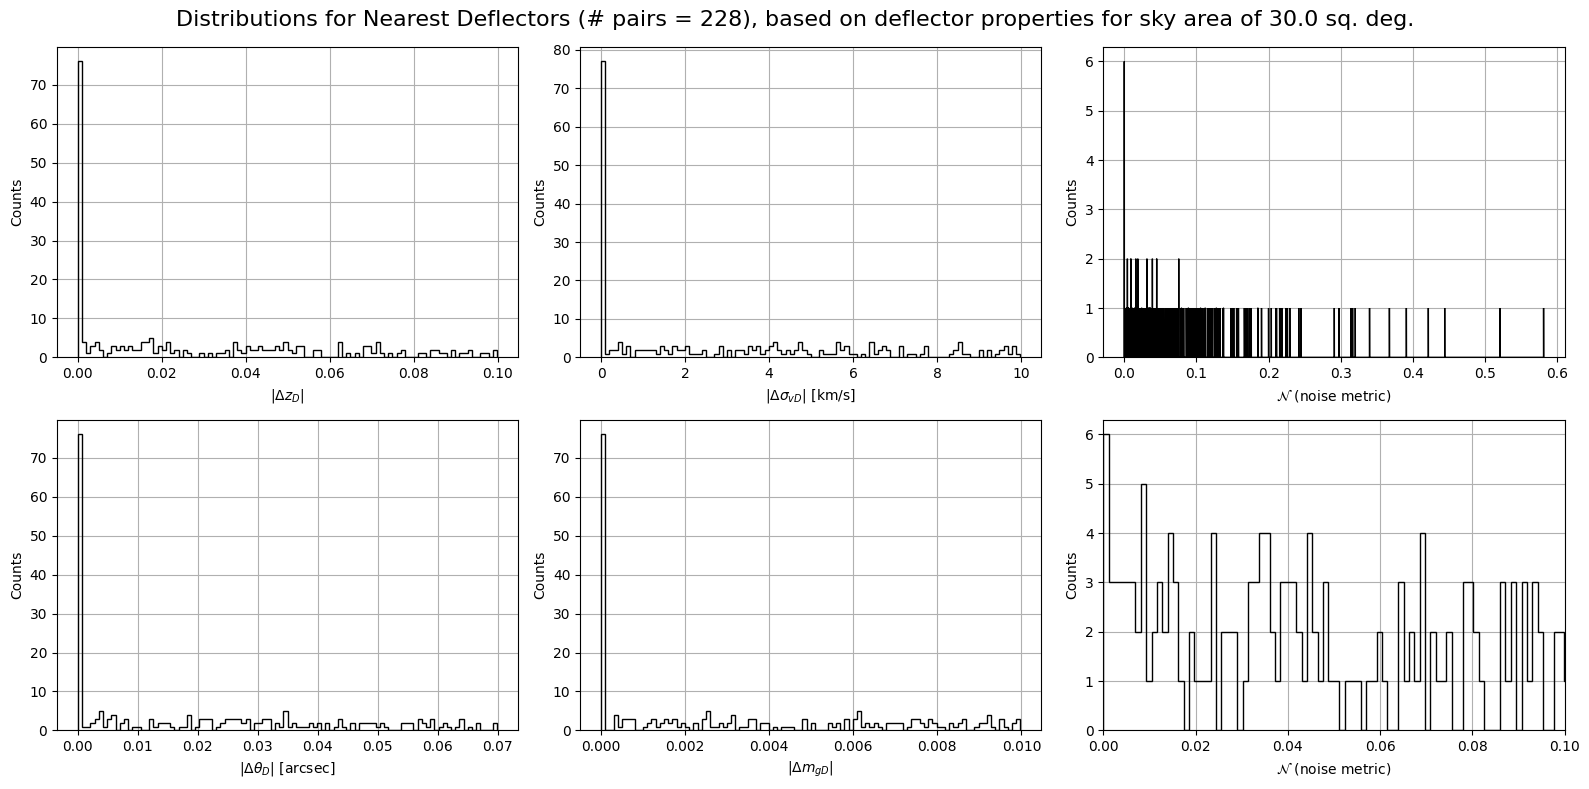

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

# plot the distribution of abs_delta_z_D, abs_delta_sigma_v_D, abs_delta_size_D, abs_delta_mag_i_D
latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{vD}|$ [km/s]",
    "abs_delta_size_D": r"$|\Delta \theta_D|$ [arcsec]",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
}
for i, param in enumerate(["abs_delta_z_D", "abs_delta_sigma_v_D", "abs_delta_size_D", "abs_delta_mag_g_D"]):
    ax[i//2, i%2].hist(
        nearest_deflector_pairs_properties[param],
        histtype='step',
        color='black',
        bins=100,
    )
    ax[i//2, i%2].set_xlabel(latex_labels[param])
    ax[i//2, i%2].set_ylabel("Counts")
    ax[i//2, i%2].grid(True)

# distribution of N for different ranges
noise_metric = nearest_deflector_pairs_properties['noise_metric']

ax[0, 2].hist(
    noise_metric,
    histtype='step',
    color = 'black',
    bins=5000,
)
# ax[0].set_xlim(0, 20)

ax[1, 2].hist(
    noise_metric[noise_metric < 2],
    histtype='step',
    color = 'black',
    bins=500,
);
ax[1, 2].set_xlim(0, .1)

for a in [ax[0, 2], ax[1, 2]]:
    a.set_xlabel("$\\mathcal{N}$ (noise metric)")
    a.set_ylabel("Counts")
    a.grid(True)

fig.suptitle("Distributions for Nearest Deflectors (# pairs = "+str(len(nearest_deflector_pairs_properties))+"), based on deflector properties for sky area of "+str(sky_area_deg2)+" sq. deg.", fontsize=16)
plt.tight_layout()

Scatter of theta_E_ratio vs theta_E1_by_theta_E2_virtual: 0.08564584405201356
Scatter of theta_E_ratio vs theta_E1_virtual_by_theta_E2: 0.09035979957730719


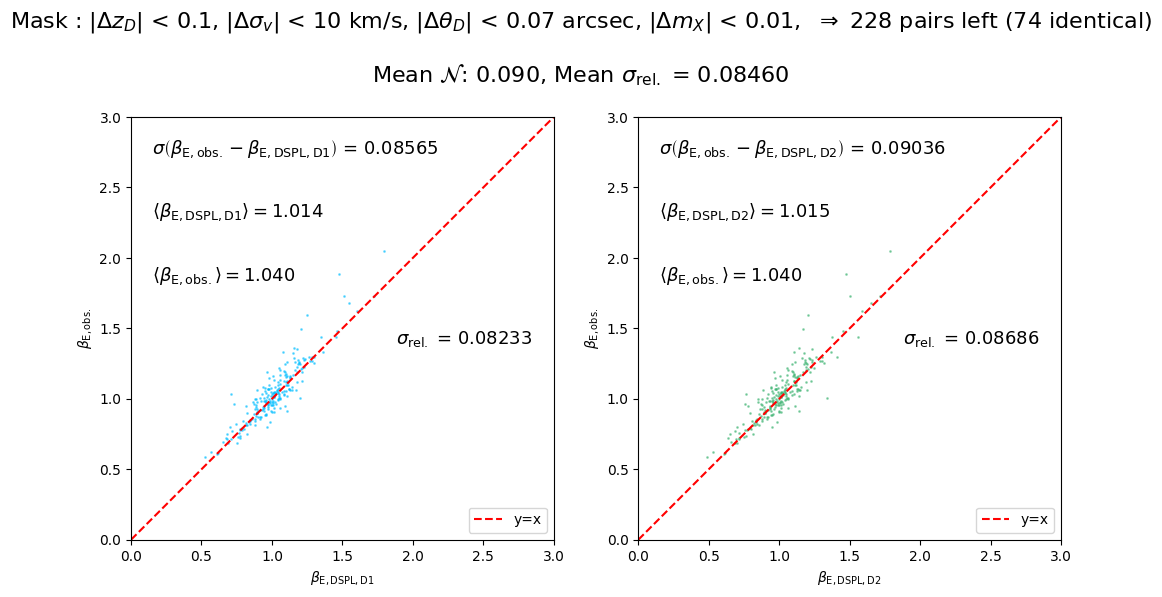

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
# Plot theta_E_ratio vs theta_E1_by_theta_E2_virtual
ax[0].scatter(
    nearest_deflector_pairs_properties["theta_E1_by_theta_E2_virtual"],
    nearest_deflector_pairs_properties["theta_E_ratio"],
    s=1,
    alpha=0.5,
    color = 'deepskyblue'
)
# ax[0].set_xlabel(r"$\theta_{E1}/\theta_{E2, virtual}$")
# ax[0].set_ylabel(r"$\theta_{E1}/\theta_{E2}$")
ax[0].set_xlabel(r"${\beta}_{\rm E, DSPL,D1}$")
ax[0].set_ylabel(r"${\beta}_{\rm E, obs.}$")

# Plot theta_E_ratio vs theta_E1_virtual_by_theta_E2
ax[1].scatter(
    nearest_deflector_pairs_properties["theta_E1_virtual_by_theta_E2"],
    nearest_deflector_pairs_properties["theta_E_ratio"],
    s=1,
    alpha=0.5,
    color = 'mediumseagreen'
)
# ax[1].set_xlabel(r"$\theta_{E1, virtual}/\theta_{E2}$")
# ax[1].set_ylabel(r"$\theta_{E1}/\theta_{E2}$")
ax[1].set_xlabel(r"${\beta}_{\rm E, DSPL,D2}$")
ax[1].set_ylabel(r"${\beta}_{\rm E, obs.}$")

for a in ax:
    a.set_xlim(0, 3)
    a.set_ylim(0, 3)
    a.plot([0, 10], [0, 10], color='red', linestyle='--', label='y=x')
    a.legend()
    a.set_aspect('equal', adjustable='box')

sigma_1 = np.std(
    nearest_deflector_pairs_properties["theta_E_ratio"] - nearest_deflector_pairs_properties["theta_E1_by_theta_E2_virtual"]
)

sigma_2 = np.std(
    nearest_deflector_pairs_properties["theta_E_ratio"] - nearest_deflector_pairs_properties["theta_E1_virtual_by_theta_E2"]
)

latex_labels = [
    r"$\sigma\left(\beta_{\rm E, obs.} - \beta_{\rm E, DSPL,D1}\right)$",
    r"$\sigma\left(\beta_{\rm E, obs.} - \beta_{\rm E, DSPL,D2}\right)$",
]

# sigma_rel = np.sqrt(sigma_1**2 + sigma_2**2)/ np.mean(nearest_deflector_pairs_properties["theta_E_ratio"])
sigma_rel = (sigma_1 + sigma_2)/ (2*np.mean(nearest_deflector_pairs_properties["theta_E_ratio"]))

# add text for sigmas
ax[0].text(0.05, 0.95, latex_labels[0]+ f" = {sigma_1:.5f}", transform=ax[0].transAxes, fontsize=13, verticalalignment='top')
ax[1].text(0.05, 0.95, latex_labels[1]+ f" = {sigma_2:.5f}", transform=ax[1].transAxes, fontsize=13, verticalalignment='top')

# add text for means
ax[0].text(0.05, 0.80, r"$\langle {\beta}_{\rm E, DSPL,D1} \rangle = $" + f"{np.mean(nearest_deflector_pairs_properties['theta_E1_by_theta_E2_virtual']):.3f}", transform=ax[0].transAxes, fontsize=13, verticalalignment='top')
ax[1].text(0.05, 0.80, r"$\langle {\beta}_{\rm E, DSPL,D2} \rangle = $" + f"{np.mean(nearest_deflector_pairs_properties['theta_E1_virtual_by_theta_E2']):.3f}", transform=ax[1].transAxes, fontsize=13, verticalalignment='top')
ax[0].text(0.05, 0.65, r"$\langle {\beta}_{\rm E, obs.} \rangle = $" + f"{np.mean(nearest_deflector_pairs_properties['theta_E_ratio']):.3f}", transform=ax[0].transAxes, fontsize=13, verticalalignment='top')
ax[1].text(0.05, 0.65, r"$\langle {\beta}_{\rm E, obs.} \rangle = $" + f"{np.mean(nearest_deflector_pairs_properties['theta_E_ratio']):.3f}", transform=ax[1].transAxes, fontsize=13, verticalalignment='top')

# relative sigmas
ax[0].text(0.95, 0.50, r"$\sigma_{\rm rel.}$" + f" = {sigma_1/np.mean(nearest_deflector_pairs_properties['theta_E_ratio']):.5f}", transform=ax[0].transAxes, fontsize=13, verticalalignment='top', horizontalalignment='right')
ax[1].text(0.95, 0.50, r"$\sigma_{\rm rel.}$" + f" = {sigma_2/np.mean(nearest_deflector_pairs_properties['theta_E_ratio']):.5f}", transform=ax[1].transAxes, fontsize=13, verticalalignment='top', horizontalalignment='right')

# save the figure
# fig.savefig("../figures/scatter_deflector_self_similarity.pdf", dpi=300, bbox_inches='tight')

fig.suptitle(
    f"Mask : $|\\Delta z_D|$ < {threshold_abs_delta_z_D}, "
    f"$|\\Delta \\sigma_v|$ < {threshold_abs_delta_sigma_v_D} km/s, "
    f"$|\\Delta \\theta_D|$ < {threshold_abs_delta_size_D} arcsec, "
    f"$|\\Delta m_X|$ < {threshold_abs_delta_mag_X_D}, "
    " $\\Rightarrow$ "+f"{len(nearest_deflector_pairs_properties)} pairs left ({len(nearest_deflector_pairs_properties[nearest_deflector_pairs_properties['abs_delta_z_D'] == 0])} identical)\n"
    "\nMean $\\mathcal{N}$: "+f"{np.mean(nearest_deflector_pairs_properties['noise_metric']):.3f}, "
    "Mean $\\sigma_{\\rm rel.}$"+ f" = {sigma_rel:.5f}"
    # "\nMean $|\\Delta \\sigma_v|$ = " + f"{np.mean(nearest_deflector_pairs_properties['abs_delta_sigma_v_D']):.5f} km/s, "+
    # "Mean $|\\Delta z_D|$ = " + f"{np.mean(nearest_deflector_pairs_properties['abs_delta_z_D']):.5f}, "+
    # "Mean $|\\Delta \\theta_D|$ = " + f"{np.mean(nearest_deflector_pairs_properties['abs_delta_size_D']):.5f} arcsec, "
    ,fontsize=16,
    y=0.95,
)

# fraction of the data points left after the mask
# print(f"Number of PDSPLs left after the mask: {np.sum(mask)}")
# print(f"Fraction of data points left after the mask: {round(100*np.sum(mask) / len(mask), 3)} %")



# find the scatter for each plot from the fitted line
print("Scatter of theta_E_ratio vs theta_E1_by_theta_E2_virtual:", np.std(
    nearest_deflector_pairs_properties["theta_E_ratio"] - nearest_deflector_pairs_properties["theta_E1_by_theta_E2_virtual"]
))
print("Scatter of theta_E_ratio vs theta_E1_virtual_by_theta_E2:", np.std(
    nearest_deflector_pairs_properties["theta_E_ratio"] - nearest_deflector_pairs_properties["theta_E1_virtual_by_theta_E2"]
))

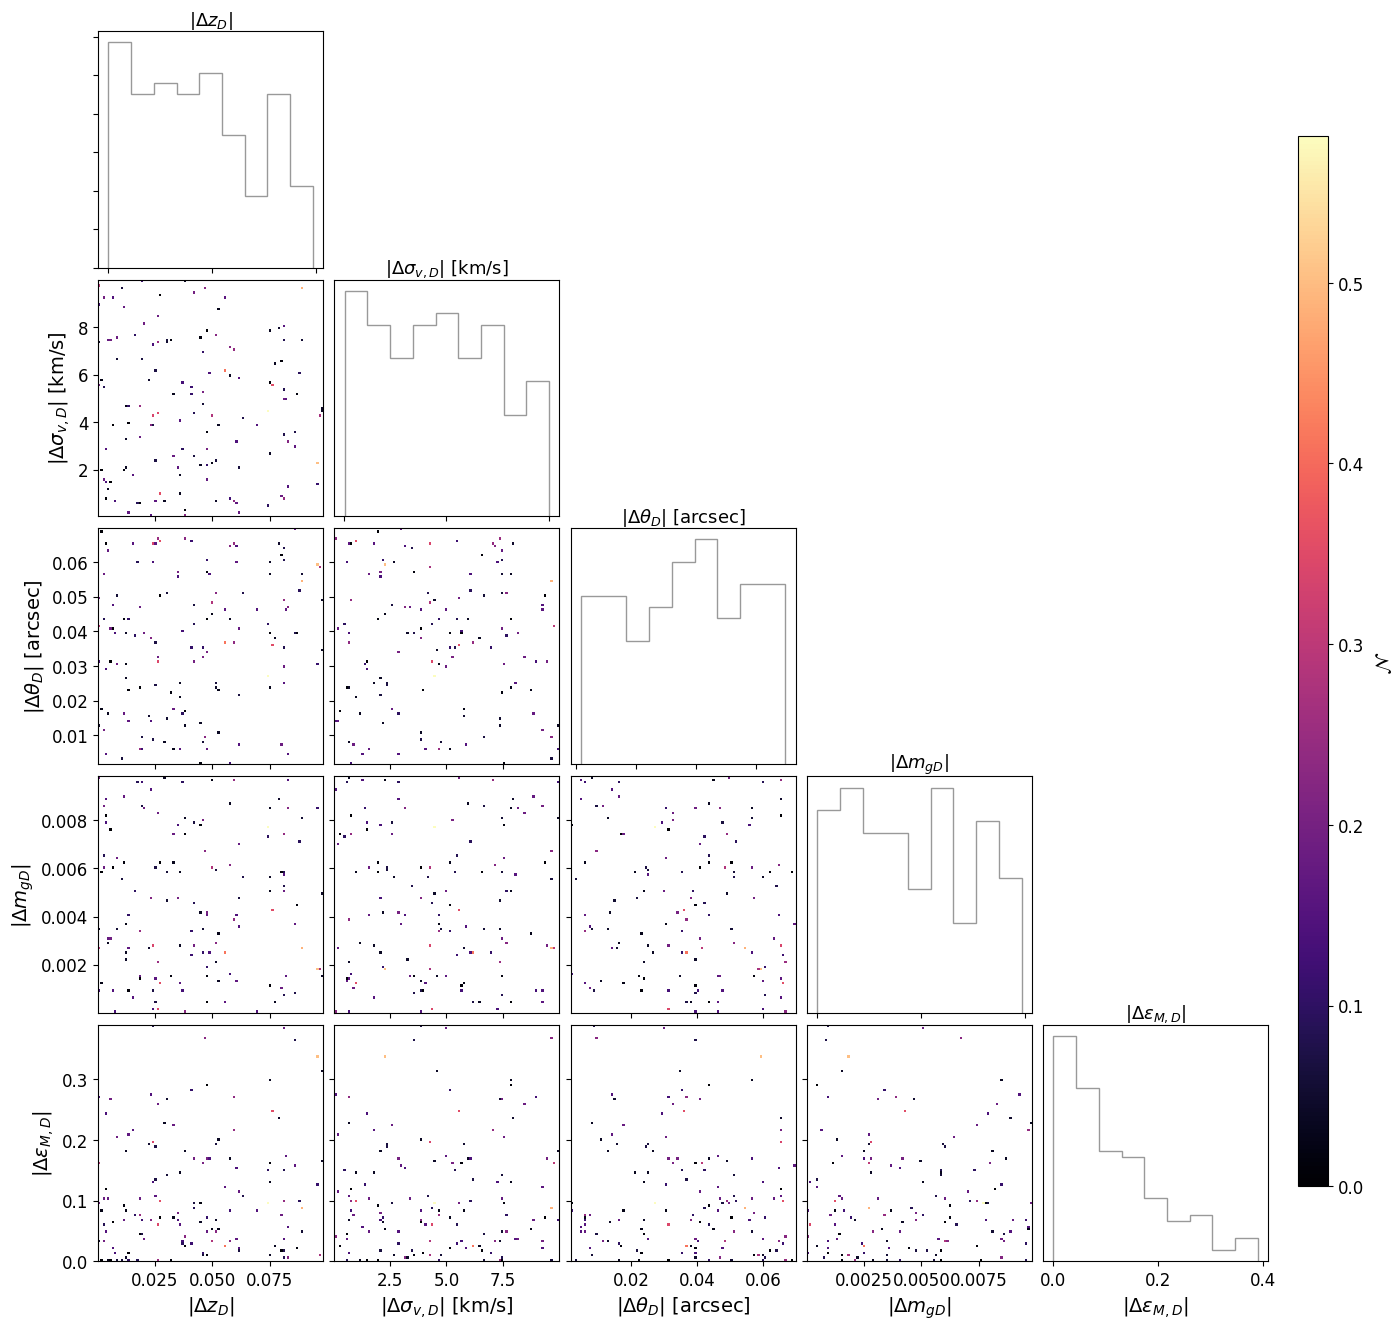

In [27]:
param_keys = [
    "abs_delta_z_D",
    "abs_delta_sigma_v_D",
    "abs_delta_size_D",
    # "abs_delta_mag_i_D",
    # "abs_delta_mag_r_D",
    "abs_delta_mag_g_D",
    # "abs_delta_mag_z_D",
    # "abs_delta_mag_y_D",
    "abs_delta_e_mass_D"
]
latex_labels = {
    "abs_delta_z_D": r"$|\Delta z_D|$",
    "abs_delta_sigma_v_D": r"$|\Delta \sigma_{v,D}|$ [km/s]",
    "abs_delta_size_D": r"$|\Delta \theta_D|$ [arcsec]",
    # "abs_delta_mag_i_D": r"$|\Delta m_{iD}|$",
    # "abs_delta_mag_r_D": r"$|\Delta m_{rD}|$",
    "abs_delta_mag_g_D": r"$|\Delta m_{gD}|$",
    # "abs_delta_mag_z_D": r"$|\Delta m_{zD}|$",
    # "abs_delta_mag_y_D": r"$|\Delta m_{yD}|$",
    "abs_delta_e_mass_D": r"$|\Delta \epsilon_{M,D}|$",
}

param_ranges = [
    (0, 0.52),  # abs_delta_z_D
    (0, 39),  # abs_delta_sigma_v_D
    (0, 0.62),  # abs_delta_size_D
    # (0, 2),    # abs_delta_mag_i_D
    # (0, 2),    # abs_delta_mag_r_D
    (0, 2.2),    # abs_delta_mag_g_D
    # (0, 2),    # abs_delta_mag_z_D
    # (0, 2),    # abs_delta_mag_y_D
    (0, 0.7)   # abs_delta_e_mass_D
]

coloring_array = nearest_deflector_pairs_properties["noise_metric"]
# coloring_array = np.exp(-coloring_array**2)

fig = plot_corner_heatmap(nearest_deflector_pairs_properties, param_keys, latex_labels, 
                    coloring_data=coloring_array, 
                    coloring_data_label="$\\mathcal{N}$",
                    # coloring_data_label="$\\exp(-\\mathcal{N}^2)$",
                    cmap='magma', 
                    # param_ranges=param_ranges,
                    heatmap_bins=100,
                    contour_levels=np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975])*np.max(coloring_array),
                    contour_kwargs={'colors': 'k', 'linewidths': 1, 'alpha': 1, 'linestyles': '--'},
                    base_fontsize=14)  # Increased base font size for better visibility

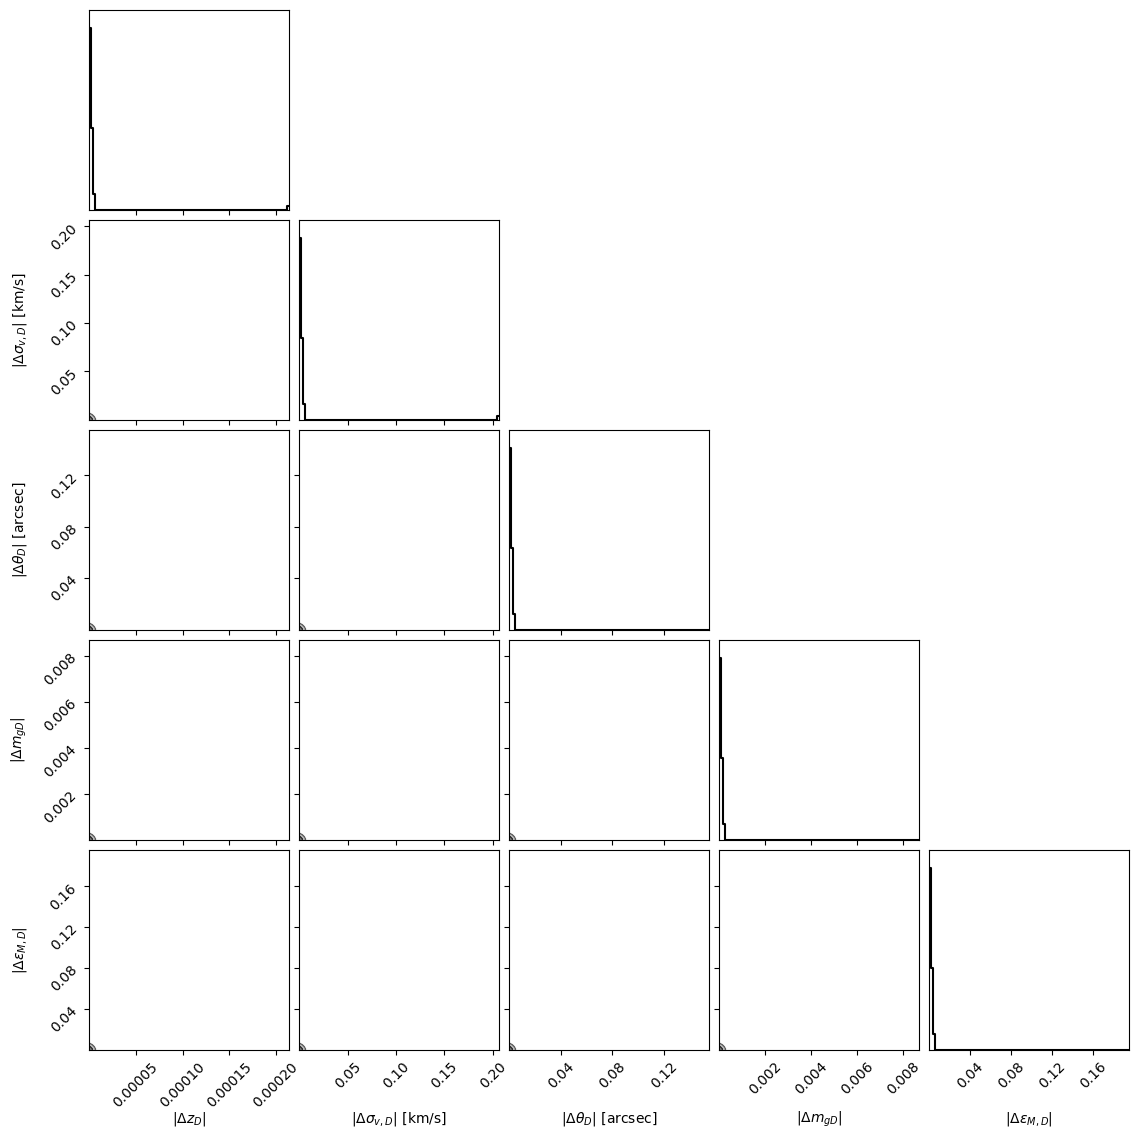

In [95]:
# corner plot 
dict_nearest_deflector_pairs_properties = {
    key: nearest_deflector_pairs_properties[key] for key in param_keys
}


corner.corner(
    dict_nearest_deflector_pairs_properties,
    labels=[latex_labels[key] for key in param_keys],
    color='black',
    bins=100,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    fill_contours=True,
    contour_kwargs={'colors': 'k', 'linewidths': 1, 'alpha': 0.5},
    levels=[0.5, 0.68, 0.95],
);